# Chapter 6: Graphs

Accompanying code for the book [The Art of Feature Engineering](http://artoffeatureengineering.com).

This notebook plus notebooks for the other chapters are available online at https://github.com/DrDub/artfeateng


## MIT License

Copyright 2019 Pablo Duboue

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Limitations

* Simple python intented for people coming from other languages that plan to use the ideas described in the book outside of Python.
* Many of these techniques are available as library calls. They are spelled out as for teaching purposes.
* Resource limitations:
 * At most one day of running time per notebook.
 * No GPU required.
 * Minimal dependencies.
 * At most 8Gb of RAM.
* Due to resource limitations, these notebooks do not undergo as much hyperparameter tuning as necessary. This is a shortcoming of these case studies, keep it in mind if you want to follow a similar path with your experiments.
* To help readers try variants of some cells in isolation, the cells are easily executable without having to re-run the whole notebook. As such, most cells read everything they need from disk and write all their results back into disk, which is unnecessary with normal notebooks. The code for each cell might look long and somewhat unusual. In a sense, each cell tries to be a separate Python program.
* I dislike Pandas so these notebooks are Pandas-free, which might seem unusual to some.

# Chapter 6: Case Study on Graph Data

In this chapter I will describe the creation of the base WikiCities dataset employed in this chapter and the next three chapters.

## WikiCities Dataset

It starts with the latest release of DBpedia [cite], for October 2016, a curated ontological resource obtained from the infoboxes at Wikipedia. Infoboxes are the tabular information appearing next to the page content in each Wikipedia page.

My intention with this dataset is to provide a task that can be attacked with regular features, with time series features, textual features and image features. The task I found that allow for all these approaches is that of calculating the population of a city or town based on their ontological properties (e.g., name of its leader or its time zone), based on its historical population and historical features (which involves a time series analysis), based on the textual description of the place (which involves text analysis, particularly as many times further includes the population) and a satellite image of the city (which involves image processing).

DBpedia files are distributed as files of triples, where a triple consists of a subject, verb and object. The subject is always an entity in the ontology, prefixed by the name space dbpedia.org. The verb is an ontological relation, of which there are many (type, leader-name, etc). The object can be either another entity or a literal value (a string or a number). Besides the actual files, DBpedia also contains links to multiple other ontologies, like Freebase or Yago plus links to the original Wikipedia articles that resulted in the extracted information. For these case studies we will be using the "instance_types_en.ttl.bz2", "mappingbased_literals_en.ttl.bz2", "mappingbased_objects_en.ttl.bz2".

The type information is derived from the infobox itself. The first challenge is to identify cities, as the "city" or "settlement" type is not thoroughly annotated in Wikipedia. Instead of relying on heuristics (such as "any entitity with a location and a population" which will result in neighborghoods annotated), I chose to use an external more reliable source, the GeoNames project. The project distributes a list of "cities or settlements with at least 1000 people". It contains 128,000+ places (file "cities1000.txt"). To link them back to DBpedia we use the file "geonames_links.ttl.bz2" distributed by DBpedia (Cell #1)

In [1]:
# CELL 1
import re
import bz2

id_re = re.compile("^(\d+)")
url_re = re.compile(".*geonames\.org\/(\d+)")

cities1000_ids = set()
with open("cities1000.txt") as cities_file:
    for line in cities_file:
        cities1000_ids.add(id_re.match(line).group(0))
print("Cities1000 total: {:,}".format(len(cities1000_ids)))

found = 0
with open("ch6_cell1_cities1000_links.ttl","w") as out:
    with bz2.BZ2File("geonames_links.ttl.bz2","r") as links:
        for byteline in links:
            if byteline[0] == ord('#'):
                continue
            line = byteline.decode("utf-8")
            if not url_re.match(line):
                print(byteline)
            if url_re.match(line).group(1) in cities1000_ids:
                out.write(line)
                found += 1            
print("In DBpedia found: {:,}".format(found))
cities1000_ids = None # free memory

Cities1000 total: 128,764
In DBpedia found: 80,251


Therefore, using the available links to DBpedia, we found 80,251 of them in the Wikipedia data set. These 80,251 plus DBpedia consitute the raw data for this problem (files "ch6_cell1_cities1000_links.ttl", ). 

Following the methodology described in Chapter 1, I will set aside 20% of this data for final evaluation at the end of the feature engineering process (Cell #2).

In [2]:
# CELL 2
import random

rand = random.Random(42)
all_cities = open("ch6_cell1_cities1000_links.ttl").readlines()
rand.shuffle(all_cities)
pivot = int(len(all_cities) * 0.8)
devset = all_cities[:pivot]
heldout = all_cities[pivot:]
with open("ch6_cell2_cities1000_dev_links.ttl", "w") as dev:
    dev.write("".join(devset))
with open("ch6_cell2_cities1000_held_links.ttl", "w") as held:
    held.write("".join(heldout))
print("Devset size: {:,}".format(len(devset)))
print("Heldout size: {:,}".format(len(heldout)))
all_cities = devset = heldout = None # free memory

Devset size: 64,200
Heldout size: 16,051


Following the methodology in Chapter 1, I now want to do some exploratory data analysis over these 64,200 settlements to decide basic featurization and model to employ.

The key issue to resolve here is to drill down on the specific relations we think will be useful to predict our target class. While DBpedia contain thousands of relations, many are seldom expressed (meaning, there are few pages where a human editor feel the need to record information such as "distante-to-London").

While we want to account the number of relations where our cities of interest partake, something to remember is that they might be value in relations that have a given city as its subject but there might also be value in relations that have the city as its object (that is, the inverse of certain relations).

Because processing the large files of DB is a computationally onerous process, I'll start by pre-filtering the triples related to all entities both forward and inverse, generating the file "ch6_cell3_cities1000_base.ttl" (Cell #3).

In [3]:
# CELL 3
city_uris = set(map(lambda line:line.split(' ')[0], open("ch6_cell1_cities1000_links.ttl").readlines()))
triple_re = re.compile("(<[^>]+>)\s(<[^>]+>)\s(.*) \.")

def compressed_triples_gen(filename):
    with bz2.BZ2File(filename,"r") as compressed:
        for byteline in compressed:
            if byteline[0] == ord('#'):
                continue
            line = byteline.decode("utf-8")
            s,v,o = triple_re.match(line).groups()
            yield line,s,v,o
            
written = 0
read = 0
with open("ch6_cell3_cities1000_base.ttl","w") as base:
    # types and literals only in subject position
    for line, subj, verb, obj in compressed_triples_gen("instance_types_en.ttl.bz2"):
        read += 1 
        if subj in city_uris:
            base.write(line)
            written += 1
    for line, subj, verb, obj in compressed_triples_gen("mappingbased_literals_en.ttl.bz2"):
        read += 1
        if subj in city_uris:
            base.write(line)
            written += 1
    for line, subj, verb, obj in compressed_triples_gen("mappingbased_objects_en.ttl.bz2"):
        read += 1
        if subj in city_uris:
            base.write(line)
            written += 1
        if obj in city_uris:
            base.write("{} {} {} .\n".format(obj, verb[0:-1] + "?inv>", subj))
            written += 1
print("Base {:,} out of {:,}".format(written, read))
city_uris = None # free memory

Base 2,014,559 out of 38,285,143


That code takes a while to run but it will speed up the rest of the work quite a bit down the road as we only need to worry now of 2 million triples instead of 38 million. The next step is to produce a filtered version just for the development and heldout sets into the files "ch6_cell4_cities1000_devset_base.ttl" and "ch6_cell4_cities1000_heldout_base.ttl", respectively (Cell #4).

In [4]:
# CELL 4
devset_uris = set(map(lambda line:line.split(' ')[0], open("ch6_cell2_cities1000_dev_links.ttl").readlines()))
triple_re = re.compile("(<[^>]+>)\s(<[^>]+>)\s(.*) \.")

devset_size = 0
with open("ch6_cell3_cities1000_base.ttl") as base:
    with open("ch6_cell4_cities1000_dev_base.ttl", "w") as devset:
        with open("ch6_cell4_cities1000_heldout_base.ttl", "w") as heldout:
            for line in base:
                subj, verb, obj = triple_re.match(line).groups()
                if subj in devset_uris:
                    devset.write(line)
                    devset_size += 1
                else:
                    heldout.write(line)
print("Devset base size: {:,} triples".format(devset_size))
devset_uris = None # free memory

Devset base size: 1,625,988 triples


These close to 1.6 million triples are our working set, 

## EDA: Exploratory Data Analysis

I'll start the Exploratory Data Analysis by visualizing 10 random entities using the Graphviz package (Cell #5). The cities are rendered as ch6_cell5_city_*.pdf

In [5]:
# CELL 5
import re
import graphviz
import random

PARAM_USE_SET_FOR_BOOK = True

devset_uris = set(map(lambda line:line.split(' ')[0], open("ch6_cell1_cities1000_links.ttl").readlines()))
rand = random.Random(42)
triple_re = re.compile("(<[^>]+>)\s(<[^>]+>)\s(.*) \.")

# stable set for book
cities = [ "Doolittle,_Texas", "Belton,_Missouri", "Poiana_Sibiului", "Unadilla,_Georgia",
          "Sankeshwar,_Karnataka", "Psevdas", "Skudai", "Santa_Maria_da_Boa_Vista",
          "Newstead,_Tasmania", "Gombi" ]

if PARAM_USE_SET_FOR_BOOK:
    cities = list(map(lambda x: "<http://dbpedia.org/resource/" + x + ">", cities))
else:
    cities = set(rand.sample(sorted(devset_uris), 10))

nodes = dict()
dots = dict()

for city_uri in cities:
    dots[city_uri] = graphviz.Digraph(format='pdf', graph_attr={'rankdir':'BT'})
    nodes[city_uri] = dict()

def cell5_make_or_return_node(city_uri, name, shape=None):
    if name in nodes[city_uri]:
        return nodes[city_uri][name]
    ret = 'N' + str(len(nodes[city_uri]))
    nodes[city_uri][name] = ret
    if shape is None:
        dots[city_uri].node(ret, name)
    else:
        dots[city_uri].node(ret, name.replace('&', ' '), shape=shape)
    return ret

for city_uri in cities:
    cell5_make_or_return_node(city_uri, city_uri, 'star')
    
rel_count = dict()
with open("ch6_cell4_cities1000_dev_base.ttl") as base:
    for line in base:
        subj, verb, obj = triple_re.match(line).groups()
        if subj in cities:
            city_uri = subj
            rel_count[verb] = rel_count.get(verb, 0) + 1
            if verb.endswith("?inv>"):
                subj, obj = obj, subj
                verb = verb[:-5] + ">"
            subj_name = cell5_make_or_return_node(city_uri, subj)
            obj_name = cell5_make_or_return_node(city_uri, obj)
            dots[city_uri].edge(subj_name, obj_name, verb)
for city_uri in cities:
    city = city_uri[:-1].split("/")[-1]
    dot = dots[city_uri]
    print("Rendering",city,":",len(dot.source.splitlines()), "dot lines")
    dot.render("ch6_cell5_city_" + city + ".dot")
with open("ch6_cell5_rel_counts.tsv", "w") as rels:
    for rel in sorted(rel_count.keys()):
        rels.write("{}\t{}\n".format(rel,rel_count[rel]))
print("\nTop relation counts:")
from IPython.display import HTML, display
display(HTML("<table><tr><th>Rel</th><th>Counts</th></tr>" +
            "\n".join(list(map(lambda r:"<tr><td>{}</td><td>{}</td></tr>".format(r[0][:-1].split("/")[-1],r[1]), 
                               sorted(rel_count.items(), key=lambda t:t[1], reverse=True)[:10]))) +
            "</table>"))

Rendering Doolittle,_Texas : 4 dot lines
Rendering Belton,_Missouri : 62 dot lines
Rendering Poiana_Sibiului : 37 dot lines
Rendering Unadilla,_Georgia : 54 dot lines
Rendering Sankeshwar,_Karnataka : 4 dot lines
Rendering Psevdas : 22 dot lines
Rendering Skudai : 41 dot lines
Rendering Santa_Maria_da_Boa_Vista : 4 dot lines
Rendering Newstead,_Tasmania : 18 dot lines
Rendering Gombi : 20 dot lines

Top relation counts:


Rel,Counts
utcOffset,10
isPartOf,10
timeZone,8
22-rdf-syntax-ns#type,7
name,7
country,7
populationTotal,5
areaTotal,4
leaderTitle,4
elevation,4


From here we can see that some randomly sampled cities are all fairly small, which talks that most rows will have very little data while others will contain the bulk of the triples. The amount of infrormation available is already a great indicator of population.

From looking at the graphs we can see that certain places (like Skudai) do not contain population information. The next step is thus to filter cities for which the population is known (as we can only use those to build a regressor or classifier).

From the relation table in "ch6_cell5_rel_counts.tsv" we can see that some relations are very rare (like homepage or leaderParty) while others are defined for almost all cities (like rdf type or areaLand). The inverse relations are also quite sparse but these places are all sparsely populated.

But first we will need to know how population is expressed in DBpedia. From Psevdas we can see it has a relation "populationTotal". Would that be the only way population is expressed? Let us see what relations contain the word population in their name (Cell #6).

In [6]:
# CELL 6
triple_re = re.compile("(<[^>]+>)\s(<[^>]+>)\s(.*) \.")

rels_of_interest = dict()
with open("ch6_cell4_cities1000_dev_base.ttl") as base:
    for line in base:
        subj, verb, obj = triple_re.match(line).groups()
        if "population" in verb:
            rels_of_interest[verb] = rels_of_interest.get(verb, 0) + 1
from IPython.display import HTML, display
display(HTML("<table><tr><th>Rel</th><th>Counts</th></tr>" +
            "\n".join(list(map(lambda r:"<tr><td>{}</td><td>{}</td></tr>".format(r[0][:-1].split("/")[-1],r[1]), 
                               sorted(rels_of_interest.items(), key=lambda t:t[1], reverse=True)))) +
            "</table>"))

Rel,Counts
populationTotal,49028
populationDensity,19540
populationAsOf,5410
populationPlace?inv,2511
populationMetro,1286
populationUrban,1188
populationTotalRanking,1057
populationMetroDensity,142
populationUrbanDensity,79
populationRural,42


It seems "populationTotal" is the right relation to use, but we will need to filter populationMetro, populationUrban and populationRural. Also, if populationTotal is not defined, either of those, if defined could be used as surrogates of out target class. But at this stage we can to filter the cities with defined population, I will put them into the file "ch6_cell7_dev_pop.tsv" and collect also the population (will require cleaning type information such as ^^<http://www.w3.org/2001/XMLSchema#nonNegativeInteger>). This number will be our target value for regression (or a discretized version of it, our target class).

I do this process on both the dev and heldout (into file "ch6_cell7_heldout_pop.tsv") in Cell #7.

In [7]:
# CELL 7
import re
from collections import OrderedDict

cities_uris = set(map(lambda line:line.split(' ')[0], open("ch6_cell1_cities1000_links.ttl").readlines()))
devset_uris = set(map(lambda line:line.split(' ')[0], open("ch6_cell2_cities1000_dev_links.ttl").readlines()))
triple_re = re.compile("(<[^>]+>)\s(<[^>]+>)\s(.*) \.")

population = OrderedDict()
with open("ch6_cell3_cities1000_base.ttl") as base:
    for line in base:
        subj, verb, obj = triple_re.match(line).groups()
        verb = verb[:-1].split("/")[-1]
        update = False
        conditional = True
        if verb == "populationTotal":
            update = True
            conditional = False
        elif verb in set(['populationMetro', 'populationUrban', 'populationRural']):
            if subj in population and population[subj][1] == 'populationTotal':
                pass # keep current
            else:
                update = True
                conditional = subj in population
        if update:
            # compute actual population
            if obj[0] == '"':
                obj = obj[1:obj[1:].index('"')+1]
            try:
                pop = float(obj)
            except ValueError:
                print("For city", subj, "cannot convert", line)
                next # ignore
            if not conditional or population[subj][0] < pop:
                population[subj] = (pop, verb)
                
dev_cities_with_pop = 0
with open("ch6_cell7_dev_pop.tsv", "w") as dev:
    with open("ch6_cell7_heldout_pop.tsv", "w") as held:
        for city, pop in population.items():
            line = "{}\t{}\n".format(city, pop[0])
            if city in devset_uris:
                dev.write(line)
                dev_cities_with_pop += 1
            else:
                held.write(line)
print("Cities with known population in devset: {:,}".format(dev_cities_with_pop))

Cities with known population in devset: 48,868


Now we can proceed to repeat the plotting of 10 random cities in the devset with known population (Cell #8).

In [8]:
# CELL 8
import re
import graphviz
import random

PARAM_USE_SET_FOR_BOOK = True

devset_uris = set(map(lambda line:line.split('\t')[0], open("ch6_cell7_dev_pop.tsv").readlines()))
rand = random.Random(42)
triple_re = re.compile("(<[^>]+>)\s(<[^>]+>)\s(.*) \.")

# stable set for book
cities = [ "Ovalle", "Hawaiian_Paradise_Park,_Hawaii", "Coupar_Angus",
          "Hilsenheim", "Esko,_Minnesota", "Hamlin,_New_York", "Falkenberg,_Märkisch-Oderland",
          "Wermelskirchen", "Berne,_Indiana", "Chennevières-sur-Marne" ]

if PARAM_USE_SET_FOR_BOOK:
    cities = list(map(lambda x: "<http://dbpedia.org/resource/" + x + ">", cities))
else:
    cities = set(rand.sample(sorted(devset_uris), 10))

nodes = dict()
dots = dict()

for city_uri in cities:
    dots[city_uri] = graphviz.Digraph(format='pdf', graph_attr={'rankdir':'BT'})
    nodes[city_uri] = dict()

for city_uri in cities:
    cell5_make_or_return_node(city_uri, city_uri, 'star')

rel_count = dict()
with open("ch6_cell4_cities1000_dev_base.ttl") as base:
    for line in base:
        subj, verb, obj = triple_re.match(line).groups()
        if subj in cities:
            city_uri = subj
            rel_count[verb] = rel_count.get(verb, 0) + 1
            if verb.endswith("?inv>"):
                subj, obj = obj, subj
                verb = verb[:-5] + ">"
            subj_name = cell5_make_or_return_node(city_uri, subj)
            obj_name = cell5_make_or_return_node(city_uri, obj)
            dots[city_uri].edge(subj_name, obj_name, verb)
for city_uri in cities:
    city = city_uri[:-1].split("/")[-1]
    dot = dots[city_uri]
    print("Rendering",city,":",len(dot.source.splitlines()), "dot lines")
    dot.render("ch6_cell8_city_" + city + ".dot")
    
with open("ch6_cell8_rel_counts.tsv", "w") as rels:
    for rel in sorted(rel_count.keys()):
        rels.write("{}\t{}\n".format(rel,rel_count[rel]))
print("\nTop relation counts:")
from IPython.display import HTML, display
display(HTML("<table><tr><th>Rel</th><th>Counts</th></tr>" +
            "\n".join(list(map(lambda r:"<tr><td>{}</td><td>{}</td></tr>".format(r[0][:-1].split("/")[-1],r[1]), 
                               sorted(rel_count.items(), key=lambda t:t[1], reverse=True)[:10]))) +
            "</table>"))

Rendering Ovalle : 59 dot lines
Rendering Hawaiian_Paradise_Park,_Hawaii : 48 dot lines
Rendering Coupar_Angus : 4 dot lines
Rendering Hilsenheim : 28 dot lines
Rendering Esko,_Minnesota : 37 dot lines
Rendering Hamlin,_New_York : 46 dot lines
Rendering Falkenberg,_Märkisch-Oderland : 32 dot lines
Rendering Wermelskirchen : 45 dot lines
Rendering Berne,_Indiana : 67 dot lines
Rendering Chennevières-sur-Marne : 20 dot lines

Top relation counts:


Rel,Counts
isPartOf,11
name,10
areaCode,10
22-rdf-syntax-ns#type,9
elevation,9
populationTotal,9
country,9
areaTotal,8
postalCode,8
birthPlace?inv,8


These cities with defined population have definitely much more things going on for them, including multiple areaCode relations (three in the case of Wermelskirchen) and a variety of inverse relations. At this stage on the EDA process we want to look into which of these relations might make for good features. Going back to Chapter 1, we want features that will be simple, related to the target (population) and readily available. From the perspective of "readily available" we want to shorten down the number of relations to ones that are frequent enough that will be useful for a ML algorithm (I will look into the other issues later). Therefore their frequency over the whole set of entities is paramount. Let us sort the relations by the number of cities that have them defined (Cell #9). 

In [9]:
# CELL 9
import re
from collections import OrderedDict

devset_uris = set(map(lambda line:line.split('\t')[0], open("ch6_cell7_dev_pop.tsv").readlines()))
triple_re = re.compile("(<[^>]+>)\s(<[^>]+>)\s(.*) \.")

rel_count = OrderedDict()
rel_subj_seen = set()
with open("ch6_cell4_cities1000_dev_base.ttl") as base:
    for line in base:
        subj, verb, obj = triple_re.match(line).groups()
        if subj in devset_uris:
            rel_subj = "{}-{}".format(subj,verb)
            if rel_subj not in rel_subj_seen:
                rel_count[verb] = rel_count.get(verb, 0) + 1
                rel_subj_seen.add(rel_subj)
sorted_count = sorted(rel_count.items(), key=lambda t:t[1])

# drop long names
sorted_count = list(map(lambda t:(t[0][:-1].split("/")[-1], str(t[1])), sorted_count))
table = list()
step = int(len(sorted_count) / 10)
print("Total relations", len(sorted_count), "percentile size", step)
table.append( ("First", sorted_count[0][0], sorted_count[0][1], 
              "{}%".format(int(float(sorted_count[0][1]) / len(devset_uris) * 10000) / 100) ))
current = step
percentile = 1
while current < len(sorted_count):
    table.append( ("At {} percentile".format(percentile*10), sorted_count[current][0],
                 sorted_count[current][1],
                 "{}%".format(int(float(sorted_count[current][1]) / len(devset_uris) * 10000) / 100) ) )
    current += step
    percentile += 1
table.append( ("Last", sorted_count[-1][0], sorted_count[-1][1], 
              "{}%".format(int(float(sorted_count[-1][1]) / len(devset_uris) * 10000) / 100) ))


from IPython.display import HTML, display
display(HTML("<table><tr><th>Pos</th><th>Rel</th><th>Counts</th><th>Percentage of cities defined</th></tr>" +
            "\n".join(list(map(lambda r:"<tr><td>" + "</td><td>".join(r) + "</td></tr>", table))) +
            "</table>"))

Total relations 347 percentile size 34


Pos,Rel,Counts,Percentage of cities defined
First,buildingEndDate,1,0.0%
At 10 percentile,sportCountry?inv,1,0.0%
At 20 percentile,lowestState,3,0.0%
At 30 percentile,inflow?inv,5,0.01%
At 40 percentile,board?inv,9,0.01%
At 50 percentile,riverMouth?inv,27,0.05%
At 60 percentile,county?inv,78,0.15%
At 70 percentile,knownFor?inv,209,0.42%
At 80 percentile,populationTotalRanking,699,1.43%
At 90 percentile,headquarter?inv,2769,5.66%


Which relation we will use is key to success of the ML, at this stage we will overselect and then drill down to find a better subset. But we don't want to select too many, particularly ones are not that useful, so anything appearing less than 5% of the time is not really that useful, even if looks very appealing (such as "populationTotalRanking", only available for 1.43% of the cities in the devset). The next stage is then write down the list of final relations (file "ch6_cell10_rels.txt") and filter the devset to only those triples (file "ch6_cell10_cities100_dev_filtered.ttl"). That will also further reduce the computation down the road. Cell #10.

In [10]:
# CELL 10
import re
from collections import OrderedDict

devset_uris = set(map(lambda line:line.split('\t')[0], open("ch6_cell7_dev_pop.tsv").readlines()))
triple_re = re.compile("(<[^>]+>)\s(<[^>]+>)\s(.*) \.")

rel_count = OrderedDict()
rel_subj_seen = set()
with open("ch6_cell4_cities1000_dev_base.ttl") as base:
    for line in base:
        subj, verb, obj = triple_re.match(line).groups()
        if subj in devset_uris:
            rel_subj = "{}-{}".format(subj,verb)
            if rel_subj not in rel_subj_seen:
                rel_count[verb] = rel_count.get(verb, 0) + 1
                rel_subj_seen.add(rel_subj)

# delete populations
del rel_count["<http://dbpedia.org/ontology/populationTotal>"]
del rel_count["<http://dbpedia.org/ontology/populationMetro>"]
del rel_count["<http://dbpedia.org/ontology/populationUrban>"]
del rel_count["<http://dbpedia.org/ontology/populationRural>"]
                
threshold = len(devset_uris) * 0.05
selected_rels = sorted(filter(lambda t:t[1] >= threshold, rel_count.items()), key=lambda t:t[0])

with open("ch6_cell10_rels.txt", "w") as rels:
    rels.write("\n".join(map(lambda t:t[0], selected_rels))+"\n")

selected_rels = set(map(lambda t:t[0], selected_rels))
written = 0
with open("ch6_cell10_cities1000_dev_filtered.ttl", "w") as filtered:
    with open("ch6_cell4_cities1000_dev_base.ttl") as base:
        for line in base:
            subj, verb, obj = triple_re.match(line).groups()
            if subj in devset_uris and verb in selected_rels:
                filtered.write(line)
                written += 1

print("Selected", len(selected_rels), "relations")
print("Filtered down to {:,} triples".format(written))

Selected 43 relations
Filtered down to 1,278,943 triples


From all this process we are now down to 43 relations and 1.3 million triples for 48,000 instances. But we still do not have features, as these relations have multiple instances for them and are unordered. To deal with this situation, we can remember the techniques from Chapter 5 for dealing sets, lists, graphs, etc. For the set-based (unordered) nature of the relations, we can sort them. In this case we can sort them by how frequent is the target value. If the target value is more frequent, it might be more informative to the ML. That leaves then with a list of values for each relation. To represent lists, a common technique is to truncate it to a maximum size. We thus need to see how many times each of these 43 relations is defined for a given entity (Cell #11).

In [11]:
# CELL 11
import re
from collections import OrderedDict

triple_re = re.compile("(<[^>]+>)\s(<[^>]+>)\s(.*) \.")

rel_count_per_city = OrderedDict()
with open("ch6_cell10_cities1000_dev_filtered.ttl") as base:
    for line in base:
        subj, verb, obj = triple_re.match(line).groups()
        if verb not in rel_count_per_city:
            rel_count_per_city[verb] = OrderedDict()
        rel_count_per_city[verb][subj] = rel_count_per_city[verb].get(subj, 0) + 1

# sort and compute min, max, average and median
table = list()
for rel in sorted(rel_count_per_city.keys()):
    city_counts = sorted(rel_count_per_city[rel].items(), key=lambda t:t[1])
    city_counts = list(map(lambda t:(t[0][:-1].split("/")[-1],t[1]), city_counts))
    table.append( (rel[:-1].split("/")[-1], # rel 
                   len(city_counts), # counts
          city_counts[-1], # max
          int(sum(map(lambda t:t[1], city_counts)) / len(city_counts) * 100) / 100, # avg
          city_counts[int(len(city_counts) / 2)], # median
          city_counts[0])  # min  
    )
from IPython.display import HTML, display
display(HTML("<table><tr><th>Rel</th><th>Counts</th><th>Max</th><th>Avg</th><th>Median</th><th>Min</th></tr>" +
            "\n".join(list(map(lambda r:"<tr><td>"+"</td><td>".join(list(map(str,r)))+
                               "</td></tr>", table))) +"</table>"))

Rel,Counts,Max,Avg,Median,Min
area,4803,"('Saint-Germain-Nuelles', 1)",1.0,"('Labeuvrière', 1)","('Austin,_Texas', 1)"
areaCode,25417,"('Iserlohn', 8)",1.14,"('Martin,_Slovakia', 1)","('Ankara', 1)"
areaLand,11669,"('Spotswood,_New_Jersey', 2)",1.69,"('Reinbeck,_Iowa', 2)","('Amsterdam', 1)"
areaTotal,29917,"('Spotswood,_New_Jersey', 2)",1.27,"('Osann-Monzel', 1)","('Ankara', 1)"
areaWater,10950,"('Spotswood,_New_Jersey', 2)",1.42,"('Mebane,_North_Carolina', 1)","('Amsterdam', 1)"
birthPlace?inv,21089,"('London', 6258)",13.31,"('Itō,_Shizuoka', 3)","('Kaysersberg', 1)"
city?inv,13551,"('London', 709)",3.9,"('Ashburnham,_Massachusetts', 2)","('Iquitos', 1)"
country,45977,"('Sada,_Galicia', 8)",1.04,"('Talence', 1)","('Ankara', 1)"
deathPlace?inv,10046,"('London', 3059)",8.36,"('Longmeadow,_Massachusetts', 2)","('Sauk_City,_Wisconsin', 1)"
department,2587,"('Saint-Denis,_Seine-Saint-Denis', 1)",1.0,"('Trémuson', 1)","('Ajaccio', 1)"


There are multiple things we can see here. First, no relation has a minimum that it is not 1. That is good because it means no relation is inherently multiple. We can also see that the inverted relations have substantive maximums, which make sense that cities such as London will be the birthplaces of thousands of Wikipedia-worthy people. Clearly the most important signal here is the number of such inbound relations rather than the actual entities being referred, but we will leave that to be brought about by some feature selection techniques as the ones discussed in Chapter 4. Some the averages are also pretty high but they seem to be driven by few megacities. The medians are much informative, with only a few beyond one. I will thus focus on the medians and extract the file "ch6_cell12_rels_median_fan_outs.tsv" (Cell #12).

In [12]:
# CELL 12
import re
from collections import OrderedDict

triple_re = re.compile("(<[^>]+>)\s(<[^>]+>)\s(.*) \.")

rel_count_per_city = OrderedDict()
with open("ch6_cell10_cities1000_dev_filtered.ttl") as base:
    for line in base:
        subj, verb, obj = triple_re.match(line).groups()
        if verb not in rel_count_per_city:
            rel_count_per_city[verb] = OrderedDict()
        rel_count_per_city[verb][subj] = rel_count_per_city[verb].get(subj, 0) + 1

# sort and compute min, max, average and median
with open("ch6_cell12_rels_median_fan_outs.tsv", "w") as medians:
    for rel in sorted(rel_count_per_city.keys()):
        city_counts = sorted(rel_count_per_city[rel].items(), key=lambda t:t[1])
        medians.write("{}\t{}\n".format(rel,city_counts[int(len(city_counts) / 2)][1]))

## Base Featurization

We are now almost ready to produce a base featurization, all we are missing is to have global counts for all literals and entities that are targets of the relations and use them to sort and select the top ones according to the median fan-out computed in Cell #11. To such features I will also add the total count per relation and a large total of all relevant relations. Missing features are marked by the string "N/A". Adding the population produces the file "ch6_cell13_dev_feat0.tsv", the first full featurization of the dataset (Cell #13).

In [13]:
# CELL 13
import re
from collections import OrderedDict

triple_re = re.compile("(<[^>]+>)\s(<[^>]+>)\s(.*) \.")

# compute counts for ordering values
popularity = dict()
with open("ch6_cell10_cities1000_dev_filtered.ttl") as base:
    for line in base:
        subj, verb, obj = triple_re.match(line).groups()
        popularity[obj] = popularity.get(obj, 0) + 1

# fan outs
fan_outs = dict()
with open("ch6_cell12_rels_median_fan_outs.tsv") as medians:
    for line in medians:
        rel, fan_out = line.strip().split("\t")
        fan_outs[rel] = int(fan_out)
rels = sorted(fan_outs.keys())
        
# population
pops = dict()
with open("ch6_cell7_dev_pop.tsv") as dev_pop:
    for line in dev_pop:
        city, pop = line.strip().split("\t")
        pops[city] = float(pop)
        
# full graph
graph = OrderedDict()
with open("ch6_cell10_cities1000_dev_filtered.ttl") as base:
    for line in base:
        subj, verb, obj = triple_re.match(line).groups()
        if verb in fan_outs:
            if subj not in graph:
                graph[subj] = OrderedDict()
            if verb not in graph[subj]:
                graph[subj][verb] = list()
            graph[subj][verb].append(obj)

# putting it all together
rows_written = 0
with open("ch6_cell13_dev_feat0.tsv", "w") as feats:
    # header
    feats.write("name\trel#count")
    rel_start = dict()
    idx = 2
    for rel in rels:
        fan_out = fan_outs[rel]
        rel_start[rel] = idx
        rel = rel[1:-1]
        feats.write("\t{}#count".format(rel))
        for i in range(fan_out):
            feats.write("\t{}#{}".format(rel, i+1))
        idx += fan_out + 1
    feats.write("\tpopulation\n")
    rows_written += 1
    
    # data
    for city, data in graph.items():
        feats.write("{}\t{}".format(city, sum(map(len,data.values()))))
        for rel in rels:
            fan_out = fan_outs[rel]
            if rel not in data:
                feats.write("\tNA" * (fan_out + 1))
            else:
                feats.write("\t{}".format(len(data[rel])))
                values = sorted(data[rel], key=lambda o:popularity[o], reverse=True)[:fan_out]
                feats.write("\t" + "\t".join(values))
                written = len(values)
                while written < fan_out:
                    feats.write("\tNA")
                    written += 1
        feats.write("\t{}\n".format(pops[city]))
        rows_written += 1
print("Rows written (including header): {:,}".format(rows_written))

Rows written (including header): 48,869


We are now at the moment to start thinking about the ML algorithm we will employ over this data. It contains almost 100 columns of different types and a numeric target. Let us start by plotting the target and its distribution (Cell #14).

<module 'matplotlib.pyplot' from '/vol/bulk/work/feateng/finaltest/chapter6/feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

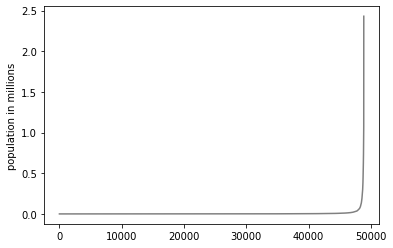

In [14]:
# CELL 14
import matplotlib.pyplot as plt
%matplotlib inline

pops = list()
with open("ch6_cell13_dev_feat0.tsv") as feats:
    next(feats) # skip header
    for line in feats:
        pops.append(float(line.strip().split("\t")[-1]) / 10e6)
pops = sorted(pops)

plt.plot(pops, label="population", color='gray')
plt.ylabel('population in millions')
plt.savefig("ch6_cell14_population.pdf", bbox_inches='tight', dpi=300)
plt

That curve is quite steep at the end. To flatten it down, we can apply a logarithmic function as it helps put such growths processes in perspective, as discussed in Chapter 3. Instead of the default logarithm on base $e$ I will use the more intuitive base 10 that tell us the number of digits in the population for a city. Cell #15 shows the result.

<module 'matplotlib.pyplot' from '/vol/bulk/work/feateng/finaltest/chapter6/feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

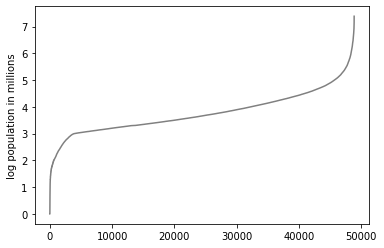

In [15]:
# CELL 15
import math
import matplotlib.pyplot as plt
%matplotlib inline

pops = list()
with open("ch6_cell13_dev_feat0.tsv") as feats:
    next(feats) # skip header
    for line in feats:
        pop = float(line.strip().split("\t")[-1])
        if pop == 0:
            pop = 1
        pops.append(math.log(pop, 10))
pops = sorted(pops)

plt.plot(pops, label="log population", color='gray')
plt.ylabel('log population in millions')
plt.savefig("ch6_cell15_log_population.pdf", bbox_inches='tight', dpi=300)
plt

The first thing to notice in this figure is that there seems to be many cities in the data set with less that 1,000 inhabitants. Some even with only 1 person! Looking a little bit into the triples, I can see that some are actual mistakes in Wikipedia (a city with 1,000,000 people got typed as 1.000.000, etc). Other are small towns and hamlets that are less than a 1,000 people (but might have been more than a 1,000 at the time GeoNames built their list). Following the discussion on outliers in Chapter 2, these are outliers that are worth removing from the data. I will still leave them in the held-out final test data as their impact in production needs to be seen and evaluated.

We thus remove these outliers and produce a filtered file "ch6_cell16_dev_feat0_filtered.tsv" (Cell #16).

In [16]:
# CELL 16
written = 0
with open("ch6_cell16_dev_feat0_filtered.tsv", "w") as filtered:
    with open("ch6_cell13_dev_feat0.tsv") as feats:
        filtered.write(next(feats))
        for line in feats:
            pop = float(line.strip().split("\t")[-1])
            if pop >= 1000:
                filtered.write(line)
                written += 1
print("Rows written (including header): {:,}".format(written))

Rows written (including header): 44,959


So we did not throw a lot of data with this change, good.

Now we can try some learning for EDA. Let us try some regression models on it against the single feature of "number of relations defined". Let's start with SVR using RBFs (Cell #17).

Training on 8,963 cities
RMSE 0.617989060494947


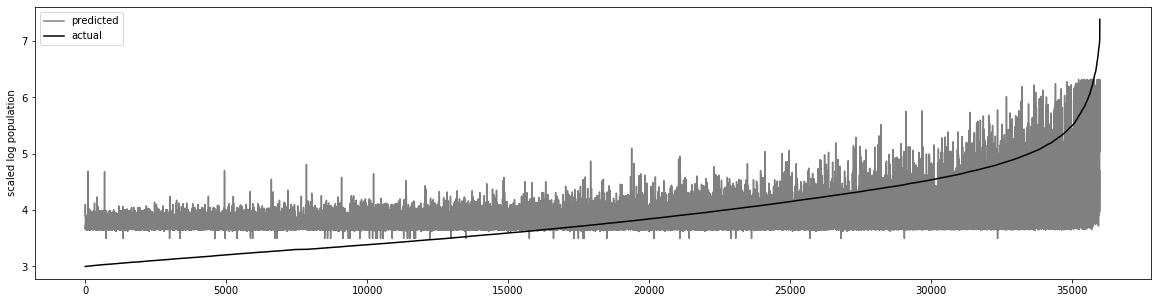

In [17]:
# CELL 17
import random
import math
from sklearn.svm import SVR
import numpy as np

rand = random.Random(42)
train_data = list()
test_data = list()
with open("ch6_cell16_dev_feat0_filtered.tsv") as feats:
    next(feats) # skip header
    for line in feats:
        fields = line.strip().split("\t")
        pop = float(fields[-1])
        rels = float(fields[1])
        row = (math.log(rels, 10), math.log(pop, 10))
        if rand.random() < 0.8:
            test_data.append(row) 
        else:
            train_data.append(row)
               
test_data = sorted(test_data, key=lambda t:t[1])

train_data = np.array(train_data)
test_data = np.array(test_data)

xtrain = train_data[:,0]
ytrain = train_data[:,1]
xtest = test_data[:,0]
ytest = test_data[:,1]

# SVRs need scaling
xtrain_min = xtrain.min(); xtrain_max = xtrain.max()
xtrain_scaling = 1.0 / (xtrain_max - xtrain_min)
xtrain -= xtrain_min
xtrain *= xtrain_scaling

ytrain_min = ytrain.min(); ytrain_max = ytrain.max()
ytrain_scaling = 1.0 / (ytrain_max - ytrain_min)
ytrain -= ytrain_min
ytrain *= ytrain_scaling

xtest -= xtrain_min
xtest *= xtrain_scaling
ytest_orig = ytest.copy()
ytest -= ytrain_min
ytest *= ytrain_scaling

# train
print("Training on {:,} cities".format(len(xtrain)))
best_c = 100.0
best_epsilon = 0.1
PARAM_DO_GRID_SEARCH = False
      
if PARAM_DO_GRID_SEARCH:
    best_rmse = 1000
    for c in [0.01, 0.1, 1.0, 2.0, 5.0, 10.0, 50.0, 100.0]:
        svr_rbf = SVR(epsilon=0.05, C=c, gamma='auto')
        svr_rbf.fit(xtrain.reshape(-1,1), ytrain)
        ytest_pred = svr_rbf.predict(xtest.reshape(-1,1))
        ytest_pred *= 1.0/ytrain_scaling
        ytest_pred += ytrain_min
        RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
        print("C", c, "RMSE", RMSE)
        if RMSE < best_rmse:
            best_c = c
            best_rmse = RMSE

    print("Best C", best_c,"best RMSE", best_rmse)        

    best_rmse = 1000
    for epsilon in [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.0, 1.0, 10.0, 100.0]:
        svr_rbf = SVR(epsilon=epsilon, C=best_c, gamma='auto')
        svr_rbf.fit(xtrain.reshape(-1,1), ytrain)
        ytest_pred = svr_rbf.predict(xtest.reshape(-1,1))
        ytest_pred *= 1.0/ytrain_scaling
        ytest_pred += ytrain_min
        RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
        print("Epsilon", epsilon, "RMSE", RMSE)
        if RMSE < best_rmse:
            best_epsilon = epsilon
            best_rmse = RMSE

    print("Best epsilon", best_epsilon,"best RMSE", best_rmse)
svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
svr_rbf.fit(xtrain.reshape(-1,1), ytrain)
ytest_pred = svr_rbf.predict(xtest.reshape(-1,1))
ytest_pred *= 1.0/ytrain_scaling
ytest_pred += ytrain_min
RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest_orig, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch6_cell17_svr_one_feat.pdf", bbox_inches='tight', dpi=300)
plt.legend()

While the RMSE is not that bad for only one feature (less that one order of magnitude) and the flat bottom of the figure can be explained by the fact the SVR has only a single support vector (from its single feature), the figure still does not seem to track the curve that well. To further see if this is an issue with SVR or with the feature, I plotted a 20% sample of the total number of relations against the log of the population in Cell #18.

<module 'matplotlib.pyplot' from '/vol/bulk/work/feateng/finaltest/chapter6/feateng/lib/python3.7/site-packages/matplotlib/pyplot.py'>

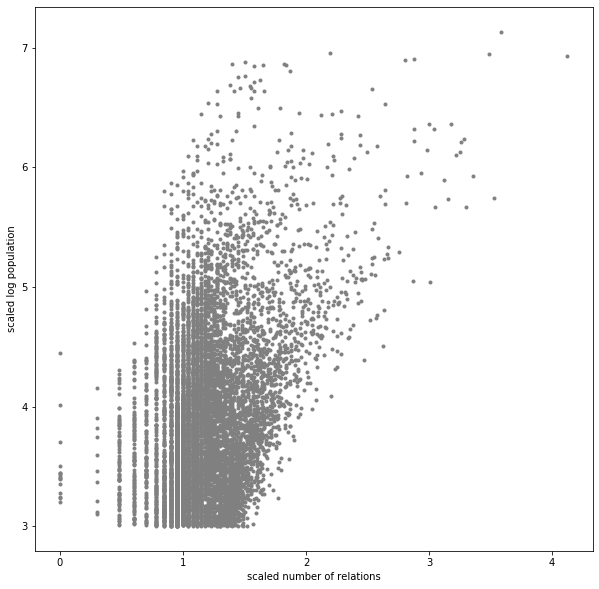

In [18]:
# CELL 18
import math
import random

pops = list()
num_rels = list()
rand = random.Random(42)
with open("ch6_cell16_dev_feat0_filtered.tsv") as feats:
    next(feats) # skip header
    for line in feats:
        fields = line.strip().split("\t")
        pop = float(fields[-1])
        rels = float(fields[1])
        if rand.random() < 0.2:
            pops.append(math.log(pop, 10))
            num_rels.append(math.log(rels, 10))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(num_rels, pops, '.', color='gray')
plt.ylabel('scaled log population')
plt.xlabel('scaled number of relations')
plt.savefig("ch6_cell18_logpop_vs_log_items.pdf", bbox_inches='tight', dpi=300)
plt

It seems the correlation is there but it is weak and SVR is extracting as good information as it is. I thus settle for SVR and we are ready for our first feature set.

## First Featurization

As SVR only takes numeric features, the first step is to typify the raw columns we have and see which ones are quasi-numeric (that is, numeric 80% of the time) and whether the ones that are not have a small (100 or less) unique values. This typification is in Cell #19.

In [19]:
# CELL 19
types = dict()
data = list()
header = None
with open("ch6_cell16_dev_feat0_filtered.tsv") as feats:
    header = next(feats).strip().split('\t')
    for line in feats:
        data.append( line.strip().split('\t'))

# numeric columns
num_cols = set()
for idx in range(len(header)):
    total_non_na = 0
    is_num = 0
    for row in data:
        if row[idx] == 'NA':
            continue
        total_non_na += 1
        row_val = row[idx]
        if '"^^' in row_val:
            row_val = row_val[1:row_val.index('"^^')]
        try:
            float(row_val)
            is_num += 1
        except ValueError:
            pass
    if is_num > total_non_na * 0.8:
        num_cols.add(idx)
        
print("Total cols", len(header))
print("Numeric cols", len(num_cols))

# differentiate categorical from free text, up to 100 categories
cat_cols = dict()
others = list()
for idx in range(len(header)):
    if idx in num_cols:
        continue
    values = set()
    for row in data:
        if row[idx] == 'NA':
            continue
        values.add(row[idx])
    if len(values) < 100:
        cat_cols[idx] = values
    else:
        others.append( (header[idx], len(values)) )

print("Categorical cols")
for col in sorted(cat_cols.keys()):
        print("   " + header[col])
from IPython.display import HTML, display
display(HTML("<table><tr><th>Rel</th><th>Counts</th></tr>" +
            "\n".join(list(map(lambda r: "<tr><td>{}</td><td>{}</td></tr>".format(r[0].split("/")[-1], r[1]), 
                               others))) +"</table>"))

Total cols 99
Numeric cols 54
Categorical cols
   http://dbpedia.org/ontology/utcOffset#1
   http://dbpedia.org/ontology/utcOffset#2
   http://www.w3.org/1999/02/22-rdf-syntax-ns#type#1


Rel,Counts
name,44959
areaCode#1,5667
birthPlace?inv#1,20183
birthPlace?inv#2,13748
birthPlace?inv#3,10523
city?inv#1,11381
city?inv#2,6884
country#1,253
deathPlace?inv#1,9848
deathPlace?inv#2,5215


Therefore, of the 99 columns, 54 are numeric but only 3 can be captured by 100 unique values. As we can expect more of them to be quasi-categorical, I employ a technique for category discretization discussed in Chapter 2, introducing an OTHER category to handle the rest of the values if they account for less than 20% of the total number of values (Cell #20). 

I also drop constant columns (which are uninformative) netting 50 numeric columns and 11 categorical. The remaining columns have a variety that cannot be discretized. These columns will require text processing or they are just uninformative for this approach. The selected categorical relations with their total number of categories is shown. Types go to "ch6_cell20_feat0_types.tsv".

In [20]:
# CELL 20
from collections import OrderedDict

types = dict()
data = list()
header = None
with open("ch6_cell16_dev_feat0_filtered.tsv") as feats:
    header = next(feats).strip().split('\t')
    for line in feats:
        data.append( line.strip().split('\t'))

# constant columns
const_cols = set()

for idx in range(len(header)):
    value = None
    constant = True
    for row in data:
        if row[idx] == 'NA':
            continue
        if value is None:
            value = row[idx]
        elif value != row[idx]:
            constant = False
            break
    if constant:
        const_cols.add(idx)

# integer columns
num_cols = set()
for idx in range(len(header)):
    if idx in const_cols:
        continue
    total_non_na = 0
    is_num = 0
    for row in data:
        if row[idx] == 'NA':
            continue
        total_non_na += 1
        row_val = row[idx]
        if '"^^' in row_val:
            row_val = row_val[1:row_val.index('"^^')]
        try:
            float(row_val)
            is_num += 1
        except ValueError:
            pass
    if is_num > total_non_na * 0.8:
        num_cols.add(idx)
        
print("Total cols", len(header))
print("Constant cols", len(const_cols))
print("Numeric cols", len(num_cols))

# differentiate categorical from free text, up to 100 categories, including "other"
cat_cols = dict()
others = list()
for idx in range(len(header)):
    if idx in num_cols or idx in const_cols:
        continue
    values = OrderedDict()
    total_obs = 0
    for row in data:
        if row[idx] == 'NA':
            continue
        values[row[idx]] = values.get(row[idx], 0) + 1
        total_obs += 1
    values = sorted(values.items(), key=lambda x:x[1])
    total_values = len(values)
    selected_values = list()
    selected_obs = 0
    while selected_obs * 1.0 / total_obs < 0.8 and len(selected_values) < 100:
        value, count = values.pop()
        selected_values.append(value)
        selected_obs += count
    if len(selected_values) < 100:
        selected_values.append('OTHER')
        cat_cols[idx] = selected_values
    else:
        others.append( (header[idx], total_values, int(selected_obs * 1.0 / total_obs * 10000)/100) )
        
with open("ch6_cell20_feat0_types.tsv", "w") as types:
    for idx in range(len(header)):
        types.write("{}\t{}".format(idx, header[idx]))
        if idx in num_cols:
            types.write("\tNUMERIC\n")
        elif idx in cat_cols:
            types.write("\t" + "\t".join(cat_cols[idx]) + "\n")
        else:
            types.write("\tIGNORE\n")
        
table1 = ("<table><tr><th>Rel</th><th>Categories</th></tr>" +
   "\n".join(list(map(lambda x: "<tr><td>{}</td><td>{}</td></tr>".format(header[x].split("/")[-1], 
                                                                         len(cat_cols[x])), cat_cols.keys()))) +
    "</table>")
table2 = ("<table><tr><th>Rel</th><th>Counts</th><th>% Covered @ 100</th></tr>" +
            "\n".join(list(map(lambda r: 
                               "<tr><td>{}</td><td>{}</td><td>{}</td></tr>".format(r[0].split("/")[-1], 
                                                                                   r[1], r[2]), 
                               others))) +"</table>")
from IPython.display import HTML, display
display(HTML("<h3>Categorical cols ({})</h3>".format(len(cat_cols)) + 
             table1 + "<h3>Remaining cols ({})</h3>".format(len(others)) + table2))

Total cols 99
Constant cols 4
Numeric cols 50


Rel,Categories
country#1,21
department#1,59
leaderTitle#1,4
populationAsOf#1,15
region#1,100
timeZone#1,14
type#1,29
utcOffset#1,7
utcOffset#2,6
22-rdf-syntax-ns#type#1,3


I now proceed to perform a one hot encoding of the categories (cf. Chapter 3) and imputing the values to the OTHER for categorical (cf. Chapter 2) or to 0.0 for numeric into file "ch6_cell21_dev_feat1.tsv" (Cell #21). Its vector size has 380 features plus the target variable.

In [21]:
# CELL 21
from collections import OrderedDict

types = list(map(lambda line: line.strip().split("\t"), 
                 open("ch6_cell20_feat0_types.tsv").readlines()))
header = None
data = list()
with open("ch6_cell16_dev_feat0_filtered.tsv") as feats:
    header = next(feats).strip().split('\t')
    for line in feats:
        data.append( line.strip().split('\t'))

total_size = 0
cat_to_pos = dict()
for type_line in types:
    if type_line[2] == 'NUMERIC':
        total_size += 1
    elif type_line[2] != 'IGNORE':
        cat_to_pos[int(type_line[0])] = dict(zip(type_line[2:], range(len(type_line) - 2)))
        total_size += len(type_line) - 2
    
with open("ch6_cell21_dev_feat1.tsv", "w") as feat1:
    feat1.write('name') # add name for error analysis
    for type_line in types:
        if type_line[2] == 'NUMERIC':
            feat1.write('\t' + type_line[1])
        elif type_line[2] != 'IGNORE':
            for value in type_line[2:]:
                feat1.write('\t{}@{}'.format(type_line[1], value))
    feat1.write('\n')
    for row in data:
        v = ['NA',] * (total_size + 1)
        v[0] = row[0] # add name for error analysis
        current = 1
        for type_line in types:
            idx = int(type_line[0])
            value = row[idx]
            if type_line[2] == 'NUMERIC':
                if '"^^' in value:
                    value = value[1:value.index('"^^')]
                try:
                    v[current] = str(float(value))
                except ValueError:
                    v[current] = '0.0'
                current += 1
            elif type_line[2] != 'IGNORE':
                pos = None
                if value == 'NA' or value not in cat_to_pos[idx]:
                    pos = cat_to_pos[idx]['OTHER']
                else:
                    pos = cat_to_pos[idx][value]
                for idx2 in range(len(type_line) - 2):
                    if idx2 == pos:
                        v[current] = "1.0"
                    else:
                        v[current] = "0.0"
                    current += 1
        feat1.write('\t'.join(v) + "\n")        
print("Vector size", total_size)

Vector size 381


This data set is ready to be used with SVR. Doing a grid search for its parameters and saving data for error analysis (Cell #22) we obtain a RMSE of 0.41 and the curve below.

Training on 35,971 cities
RMSE 0.41176199300264366
Writing files for error analysis


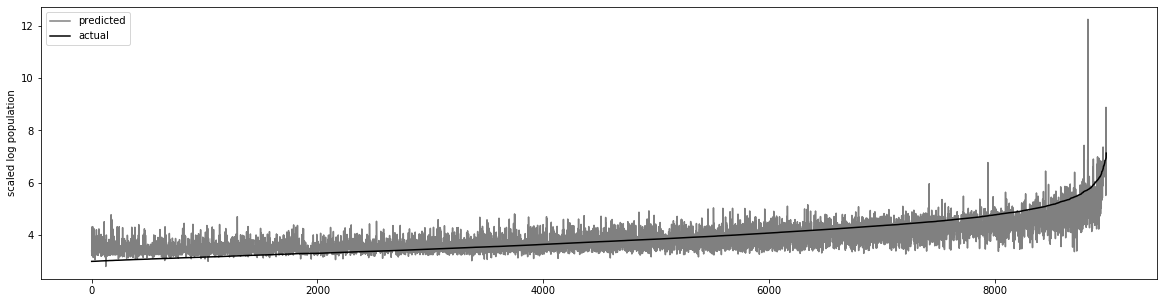

In [22]:
# CELL 22
import random
import math
from sklearn.svm import SVR
import numpy as np

rand = random.Random(42)
train_data = list()
test_data = list()
header = None
with open("ch6_cell21_dev_feat1.tsv") as feats:
    header = next(feats)
    header = header.strip().split("\t")
    for line in feats:
        fields = line.strip().split("\t")
        pop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        row = (feats, math.log(pop, 10), name)
        if rand.random() < 0.2:
            test_data.append(row) 
        else:
            train_data.append(row)
               
test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))

# SVRs need scaling
xtrain_min = xtrain.min(axis=0); xtrain_max = xtrain.max(axis=0)
# some can be zero if the column is constant in training
xtrain_diff = xtrain_max - xtrain_min
for idx in range(len(xtrain_diff)):
    if xtrain_diff[idx] == 0.0:
        xtrain_diff[idx] = 1.0
xtrain_scaling = 1.0 / xtrain_diff
xtrain -= xtrain_min; xtrain *= xtrain_scaling

ytrain_min = ytrain.min(); ytrain_max = ytrain.max()
ytrain_scaling = 1.0 / (ytrain_max - ytrain_min)
ytrain -= ytrain_min; ytrain *= ytrain_scaling

xtest -= xtrain_min; xtest *= xtrain_scaling
ytest_orig = ytest.copy()
ytest -= ytrain_min; ytest *= ytrain_scaling

# train
print("Training on {:,} cities".format(len(xtrain)))

best_c = 100.0
best_epsilon = 0.05

PARAM_DO_GRID_SEARCH = False
if PARAM_DO_GRID_SEARCH:
    best_rmse = 1000
    for c in [0.01, 0.1, 1.0, 2.0, 5.0, 10.0, 50.0, 100.0]:
        svr_rbf = SVR(epsilon=0.05, C=c, gamma='auto')
        svr_rbf.fit(xtrain, ytrain)
        ytest_pred = svr_rbf.predict(xtest)
        ytest_pred *= 1.0/ytrain_scaling
        ytest_pred += ytrain_min
        RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
        print("C", c, "RMSE", RMSE)
        if RMSE < best_rmse:
            best_c = c
            best_rmse = RMSE

    print("Best C", best_c,"best RMSE", best_rmse)        

    best_rmse = 1000
    for epsilon in [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.0, 1.0, 10.0, 100.0]:
        svr_rbf = SVR(epsilon=epsilon, C=best_c, gamma='auto')
        svr_rbf.fit(xtrain, ytrain)
        ytest_pred = svr_rbf.predict(xtest)
        ytest_pred *= 1.0/ytrain_scaling
        ytest_pred += ytrain_min
        RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
        print("Epsilon", epsilon, "RMSE", RMSE)
        if RMSE < best_rmse:
            best_epsilon = epsilon
            best_rmse = RMSE

    print("Best epsilon", best_epsilon,"best RMSE", best_rmse)
svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
svr_rbf.fit(xtrain, ytrain)
ytest_pred = svr_rbf.predict(xtest)
ytest_pred *= 1.0/ytrain_scaling
ytest_pred += ytrain_min
RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

print("Writing files for error analysis")
np.savez_compressed("ch6_cell22_feat1_svr.npz", 
                    xtrain=xtrain, ytrain=ytrain, 
                    xtest=xtest, ytest=ytest,
                    ytest_orig=ytest_orig,
                    ytest_pred=ytest_pred,
                    ytrain_min=ytrain_min,
                    xtrain_scaling=xtrain_scaling,
                    ytrain_scaling=ytrain_scaling)
with open("ch6_cell22_test_names.tsv", "w") as names:
    for idx, name in enumerate(test_names):
        names.write("{}\t{}\n".format(idx, name))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest_orig, label="actual",    color='black')
plt.ylabel('scaled log population')
plt.savefig("ch6_cell22_svr_feat1.pdf", bbox_inches='tight', dpi=300)
plt.legend()

This figure and RMSE look better than the single feature that preceed it but it has some strange spikes. Let's perform some Error Analysis on them, an error drilldown on the spike at the end by feature ablation, most probably won't work but I show error analysis.

### Error Analysis

Using the training data and evaluation results from Cell #22, I can now do an error drilldown on the spike at the end by feature ablation in Cell #23.

In [23]:
# CELL 23
arrays = np.load("ch6_cell22_feat1_svr.npz")
ytest_orig = arrays['ytest_orig']
ytest_pred = arrays['ytest_pred']
test_names = list(map(lambda line:line.strip().split('\t')[-1], 
                      open("ch6_cell22_test_names.tsv").readlines()))

# find the top 10 biggest contributors to the log error
sqe = (ytest_orig - ytest_pred)**2
contributors = list()
while len(contributors) < 10:
    idx = sqe.argmax()
    contributors.append( (idx, (ytest_pred - ytest_orig)[idx]) )
    sqe[idx] = 0.0

print("Top contributors to the error")
for idx, error in contributors:
    print("{:<4}  {:<21} {:>5}    {:>10,}   {:>17,}".
          format(idx, test_names[idx][:-1].split("/")[-1], int(error*100)/100, 
          int(10**ytest_orig[idx]), int(10**ytest_pred[idx])))                 

Top contributors to the error
8825  Dublin                  6.5       553,164   1,751,459,207,216
8726  Saint-Prex            -2.09       312,010               2,485
8705  Meads,_Kentucky       -2.08       288,648               2,351
7939  Nicosia                2.03        55,013           5,931,549
8921  Hofuf                 -1.94     1,500,000              17,145
8985  Mexico_City            1.93     8,918,652         761,989,297
8689  Montana_City,_Montana -1.88       271,529               3,513
8902  Pikine                -1.82     1,170,790              17,470
8791  Edinburgh              1.76       464,989          26,976,492
172   Isabela,_Basilan       1.74         1,081              60,349


From the table we can see that cities that have a rich history but are not necessarily that populated get overshoot by the system. Makes sense.

Interestingly, Saint-Prex is actually about 5,000 people, the 300,000 number is an extraction mistake. Meads, Kentucky population is listed on Wikipedia as 280,000 but it is being flagged as an error as 280,000 is the size of the full region. The town itself is definitely less than 5,000 people.

Nicosia is a history-rich city populated by 4,500 years. Sadly, it is a divided city and one of its divisions population is about 55,000 people. A joint city will total about 300,000 inhabitants, but it has the history of a 6,000,000 people for sure.

Therefore we have history-rich, underpopulated cities and extraction errors. From here it makes sense to focus on real (not logarithmic) where the system is over predicting (Cell #24).

In [24]:
# CELL 24
arrays = np.load("ch6_cell22_feat1_svr.npz")
xtrain = arrays['xtrain']
ytrain = arrays['ytrain'] 
xtest = arrays['xtest']
ytest = arrays['ytest']
ytest_orig = arrays['ytest_orig']
ytest_pred = arrays['ytest_pred']
test_names = list(map(lambda line:line.strip().split('\t')[-1], 
                      open("ch6_cell22_test_names.tsv").readlines()))

# find the top 10 biggest contributors to the actual error
real_error = (10**ytest_pred - 10**ytest_orig)
contributors = list()
cumulative_error = 0
while len(contributors) < 10:
    idx = real_error.argmax()
    contributors.append( (idx, (ytest_pred - ytest_orig)[idx]) )
    cumulative_error += ytest_pred[idx] - ytest_orig[idx]
    real_error[idx] = 0.0

print("Top contributors to the error")
print("Cumulative error {:,}".format(cumulative_error))
for idx, error in contributors:
    print("{:<4}  {:<21} {:>5}    {:>10,}   {:>17,}".
          format(idx, test_names[idx][:-1].split("/")[-1], int(error*100)/100, 
          int(10**ytest_orig[idx]), int(10**ytest_pred[idx])))

Top contributors to the error
Cumulative error 17.634868409695972
8825  Dublin                  6.5       553,164   1,751,459,207,216
8985  Mexico_City            1.93     8,918,652         761,989,297
8791  Edinburgh              1.76       464,989          26,976,492
8959  Algiers                0.83     3,415,810          23,294,353
8910  Prague                 0.88     1,267,448           9,823,330
8915  Milan                   0.8     1,359,904           8,636,483
8873  Amsterdam              0.98       842,342           8,094,965
8823  Lisbon                 1.15       545,245           7,776,212
8924  Tabriz                 0.74     1,549,452           8,586,162
7939  Nicosia                2.03        55,013           5,931,549


This list looks quite good, these cities are contributing a lot to the error and fall into the category of errors we have found the system is making, let's do an ablation study (wrapper) to see if we can find which features are hurting us here. In this study we'll throw away one feature at a time and see whether it improves the cumulative error for these 10 cities. The amount of computation is very big so we'll work on a 1% sample of the original data. Also, because Dublin is so markedly overshoot, I'll also keep track of dropping which better feature improves each city. Cell #25.

In [25]:
# CELL 25
import random
from sklearn.svm import SVR
import numpy as np

arrays = np.load("ch6_cell22_feat1_svr.npz")
xtrain = arrays['xtrain']
ytrain = arrays['ytrain']
ytrain_scaling = arrays['ytrain_scaling']
ytrain_min = arrays['ytrain_min']
xtest = arrays['xtest']
ytest = arrays['ytest']
ytest_orig = arrays['ytest_orig']
ytest_pred = arrays['ytest_pred']
test_names = list(map(lambda line:line.strip().split('\t')[-1], 
                      open("ch6_cell22_test_names.tsv").readlines()))
header = None
with open("ch6_cell21_dev_feat1.tsv") as feats:
    header = next(feats)
header = header.strip().split('\t')
header.pop(0) # drop name

# find the top 10 biggest contributors to the log error
real_error = (10**ytest_pred - 10**ytest_orig)
contributors = list()
cumulative_error = 0
xtest_contr = np.zeros( (10, xtest.shape[1]) )
ytest_contr = np.zeros( (10,) )
while len(contributors) < 10:
    idx = real_error.argmax()
    ytest_contr[len(contributors)] = ytest_orig[idx]
    xtest_contr[len(contributors),:] = xtest[idx,:]
    contributors.append( (idx, (ytest_pred - ytest_orig)[idx]) )
    cumulative_error += real_error[idx]
    real_error[idx] = 0.0

best_epsilon = 0.05
best_c = 100.0
# this is a lot of computation, work on sample of the original data
PARAM_SAMPLE_PERC=0.05
rand = random.Random(42)
selected = rand.sample(list(range(len(xtrain))), int(len(xtrain) * PARAM_SAMPLE_PERC))
xtrain_samp = xtrain[selected,:]
ytrain_samp = ytrain[selected]

# baseline run
svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
svr_rbf.fit(xtrain_samp, ytrain_samp)
ytest_pred = svr_rbf.predict(xtest_contr)
ytest_pred *= 1.0/ytrain_scaling
ytest_pred += ytrain_min
error = ytest_pred - ytest_contr # absolute log error
cumulative = sum(error)
baseline_cumulative = cumulative
per_city_baseline = error

best_cumulative = 100000.00
best_cumulative_ablate = None
per_city_best = [10000.00,] * 10
per_city_best_ablate = [None,] * 10

for feat in range(xtrain.shape[1]):
    if feat % int(xtrain.shape[1] / 10) == 0:
        print("{:>3} out of {:>3}".format(feat, xtrain.shape[1]))
    train_col = xtrain_samp[:,feat].copy()
    xtrain_samp[:,feat] = 0.0 # nuke feature
    svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
    svr_rbf.fit(xtrain_samp, ytrain_samp)
    ytest_pred = svr_rbf.predict(xtest_contr)
    ytest_pred *= 1.0/ytrain_scaling
    ytest_pred += ytrain_min
    error = ytest_pred - ytest_contr
    cumulative = sum(error)
    if best_cumulative_ablate is None or best_cumulative > cumulative:
        best_cumulative_ablate = feat
        best_cumulative = cumulative
    for idx in range(10):
        if per_city_best_ablate[idx] is None or per_city_best[idx] > error[idx]:
            per_city_best_ablate[idx] = feat
            per_city_best[idx] = error[idx]
    xtrain_samp[:,feat] = train_col # restore

print("Ablation study")
print("Best overall from {:3.2} to {:3.2} ({:.2%})".format(
    baseline_cumulative, best_cumulative,
    (baseline_cumulative-best_cumulative)/baseline_cumulative))
print("Feature to ablate ({}): {}\n\n".format(best_cumulative_ablate, header[best_cumulative_ablate]))
for idx in range(10):
    print("For city {} from {:3.2} to {:3.2} ({:.2%})".format(
        test_names[contributors[idx][0]][:-1].split("/")[-1],
        per_city_baseline[idx], per_city_best[idx],
        (per_city_baseline[idx]-per_city_best[idx])/per_city_baseline[idx]))
    print("Feature to ablate ({}): {}\n".format(per_city_best_ablate[idx], header[per_city_best_ablate[idx]]))

  0 out of 380
 38 out of 380
 76 out of 380
114 out of 380
152 out of 380
190 out of 380
228 out of 380
266 out of 380
304 out of 380
342 out of 380
Ablation study
Best overall from 0.28 to -2.4 (968.43%)
Feature to ablate (303): http://www.w3.org/2000/01/rdf-schema#seeAlso#count


For city Dublin from 1.2 to 0.48 (58.97%)
Feature to ablate (11): http://dbpedia.org/ontology/city?inv#count

For city Mexico_City from -0.061 to -0.4 (-561.55%)
Feature to ablate (303): http://www.w3.org/2000/01/rdf-schema#seeAlso#count

For city Edinburgh from 0.43 to 0.19 (57.03%)
Feature to ablate (3): http://dbpedia.org/ontology/areaLand#count

For city Algiers from -0.92 to -1.1 (-22.87%)
Feature to ablate (378): http://xmlns.com/foaf/0.1/name#count

For city Prague from -0.18 to -0.82 (-341.93%)
Feature to ablate (303): http://www.w3.org/2000/01/rdf-schema#seeAlso#count

For city Milan from 0.17 to -0.43 (347.88%)
Feature to ablate (307): http://www.w3.org/2000/01/rdf-schema#seeAlso#3@<http://dbpedia

From the above results I can see that counts are misleading the algorithm. Here I am presented with two options, I can either drop them or I can dampen their growth by applying a squashing function to them. As I believe there's value in them, I'll dampen their value by applying a log function to them (Cell #26).

Training on 35,971 cities
RMSE 0.3556252788046216


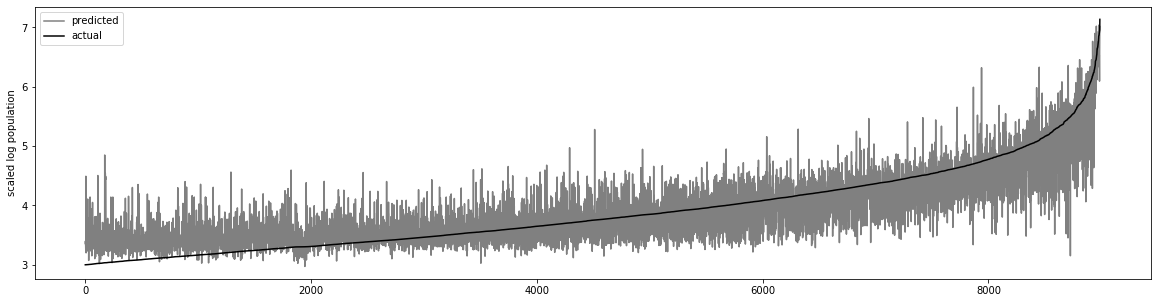

In [26]:
# CELL 26
import math
from sklearn.svm import SVR
import numpy as np

header = None
with open("ch6_cell26_dev_feat1_dampen.tsv", "w") as feats_damp:
    with open("ch6_cell21_dev_feat1.tsv") as feats:
        header = next(feats)
        feats_damp.write(header)
        header = header.strip().split("\t")
        header.pop(0) # name
        for line in feats:
            fields = line.strip().split("\t")
            pop = float(fields[-1])
            name = fields[0]
            feats = list(map(float,fields[1:-1]))
            pop = math.log(pop, 10)
            # dampen counts
            for idx, featname in enumerate(header):
                if "#count" in featname:
                    feats[idx] = math.log(feats[idx] + 1, 10)
            feats_damp.write("\t".join(map(str, [name] + feats + [pop])) + "\n")

rand = random.Random(42)
train_data = list()
test_data = list()
header = None
with open("ch6_cell26_dev_feat1_dampen.tsv") as feats:
    header = next(feats)
    header = header.strip().split("\t")
    header.pop(0) # name
    for line in feats:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        row = (feats, logpop, name)
        if rand.random() < 0.2:
            test_data.append(row) 
        else:
            train_data.append(row)
               
test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))

# SVRs need scaling
xtrain_min = xtrain.min(axis=0); xtrain_max = xtrain.max(axis=0)
# some can be zero if the column is constant in training
xtrain_diff = xtrain_max - xtrain_min
for idx in range(len(xtrain_diff)):
    if xtrain_diff[idx] == 0.0:
        xtrain_diff[idx] = 1.0
xtrain_scaling = 1.0 / xtrain_diff
xtrain -= xtrain_min; xtrain *= xtrain_scaling

ytrain_min = ytrain.min(); ytrain_max = ytrain.max()
ytrain_scaling = 1.0 / (ytrain_max - ytrain_min)
ytrain -= ytrain_min; ytrain *= ytrain_scaling

xtest -= xtrain_min; xtest *= xtrain_scaling
ytest_orig = ytest.copy()
ytest -= ytrain_min; ytest *= ytrain_scaling

# train
print("Training on {:,} cities".format(len(xtrain)))

best_c = 100.0
best_epsilon = 0.05
svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
svr_rbf.fit(xtrain, ytrain)
ytest_pred = svr_rbf.predict(xtest)
ytest_pred *= 1.0/ytrain_scaling
ytest_pred += ytrain_min
RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest_orig, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch6_cell26_svr_feat1_dampen.pdf", bbox_inches='tight', dpi=300)
plt.legend()

The RMSE is better than before at 0.36 and the spikes have reduced.

That is a nice improvement from the previous one (note that Feature Engineering does not always succeed and you might encounter dead ends). (Of course taking the log of those counts could have been done directly based on the advice in Chapter 2).

Instead of continuing in this route of wrapper ablation, I'll now move to feature utility metrics, for which we need a categorical target, I'll thus discretize the target in segments with equal number of points. Cell #27 does the discretization and measure the discretization error at different number of splits.

In [27]:
# CELL 27
import math
import random
import numpy as np

rand = random.Random(42)
train_data = list()
test_data = list()
with open("ch6_cell26_dev_feat1_dampen.tsv") as feats:
    header = next(feats)
    for line in feats:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        if rand.random() < 0.2:
            test_data.append(logpop) 
        else:
            train_data.append(logpop)

train_data = np.array(sorted(train_data))
test_data  = np.array(test_data)

def cell27_split(data):
    pivot = int(len(data)/2)
    # slower, more accurate
    lower_center, lower_val = int(pivot/2), data[int(pivot/2)]
    upper_center, upper_val = int(pivot/2)+pivot, data[int(pivot/2)+pivot]
    return [ { "min": data[0], "max": data[pivot], "val": lower_val,
              "min_idx": 0, "max_idx": pivot, "center": lower_center },
             { "min": data[pivot+1], "max": data[-1], "val": upper_val,
              "min_idx": pivot+1, "max_idx": len(data) - 1, "center": upper_center } ]

def cell27_segment(train_data, order):
    segments_at = [ [ { "min": train_data[0], "max" : train_data[-1], 
                        "val": train_data[int(len(train_data)/2)],
                        "min_idx":0, "max_idx": len(train_data) - 1 } ] ]
    for exp in range(order):
        previous = segments_at[-1]
        new_segment = list()
        for old_segment in previous:
            splitted = cell27_split(train_data[old_segment['min_idx']:(old_segment['max_idx']+1)])
            for created in splitted:
                created['min_idx'] += old_segment['min_idx']
                created['max_idx'] += old_segment['min_idx']
                created['center']  += old_segment['min_idx']
                new_segment.append(created)
        segments_at.append(new_segment)
    return segments_at

def cell27_predict(data, segments):
    result = list()
    for pop in data:
        value = None
        if pop < segments[0]['min']:
            value = segments[0]['val']
        elif pop > segments[-1]['max']:
            value = segments[-1]['val']
        else:
            for seg_idx, segment in enumerate(segments):
                if segment['min'] <= pop and \
                        (seg_idx == len(segments) - 1 or pop < segments[seg_idx + 1]['min']):
                    value = segment['val']
                    break
        if value is None:
            raise Exception("Value not found: {}".format(10**pop))
        result.append(value)
    return np.array(result)

segments_at = cell27_segment(train_data, 5)

for idx, segments in enumerate(segments_at):
    for seg_idx, seg in enumerate(segments):
        print("\tSegment {:2}, min: {:10,} value: {:10,}, max: {:10,}"
              .format((seg_idx+1), int(round(10 ** seg['min'])), 
                      int(round(10 ** seg['val'])), int(round(10 ** seg['max']))))
    test_pred = cell27_predict(test_data, segments)
    print("Segmented in {}, RMSE: {}".format(2**idx, math.sqrt(sum((test_data - test_pred)**2)/len(test_data))))
    
import pickle
with open("ch6_cell27_splits.pk", "wb") as pkl:
    pickle.dump(segments_at, pkl)

	Segment  1, min:      1,000 value:      5,409, max: 24,300,000
Segmented in 1, RMSE: 0.703382635244624
	Segment  1, min:      1,000 value:      2,226, max:      5,409
	Segment  2, min:      5,410 value:     19,435, max: 24,300,000
Segmented in 2, RMSE: 0.44244189595902794
	Segment  1, min:      1,000 value:      1,545, max:      2,226
	Segment  2, min:      2,226 value:      3,363, max:      5,409
	Segment  3, min:      5,410 value:      9,734, max:     19,435
	Segment  4, min:     19,435 value:     49,331, max: 24,300,000
Segmented in 4, RMSE: 0.2912613798706353
	Segment  1, min:      1,000 value:      1,254, max:      1,545
	Segment  2, min:      1,545 value:      1,884, max:      2,226
	Segment  3, min:      2,226 value:      2,729, max:      3,363
	Segment  4, min:      3,364 value:      4,225, max:      5,409
	Segment  5, min:      5,410 value:      7,147, max:      9,734
	Segment  6, min:      9,735 value:     13,515, max:     19,435
	Segment  7, min:     19,435 value:     29,26

From above, splitting into 4 segments produce a reasonable discretiation error. I can now proceed to do some feature selection using mutual information (Chapter 4). I will also introduce 10 random features and drop all features whose mutual information falls below at least 3 random features. Cell #28.

In [28]:
# CELL 28
import numpy as np
import pickle
import random
from collections import OrderedDict

with open("ch6_cell27_splits.pk", "rb") as pkl:
    segments_at = pickle.load(pkl)

data = list()
header = None
PARAM_RANDOM_FEATS = 10
rand = random.Random(42)
with open("ch6_cell26_dev_feat1_dampen.tsv") as feats:
    header = next(feats)
    header = header.strip().split("\t")
    header.pop(0) # name
    header.pop() # population
    for idx in range(PARAM_RANDOM_FEATS):
        header.append('random_' + str(idx))
    for line in feats:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        for _ in range(PARAM_RANDOM_FEATS):
            feats.append(rand.random())
        row = (feats, logpop, name)
        data.append(row)

xdata = np.array(list(map(lambda t:t[0], data)))
ydata = np.array(list(map(lambda t:t[1], data)))

def cell28_adjudicate(data, segments):
    result = list()
    for val in data:
        idx = None
        if val < segments[0]['min']:
            idx = 0
        elif val > segments[-1]['max']:
            idx = len(segments) - 1
        else:
            for idx2, segment in enumerate(segments):
#                if (segment['min'] == val and segment['max'] == val) or \
#                    (segment['min'] <= val and \
#                    (idx2 == len(segments)-1 or val < segments[idx2+1]['min'])):
                if segment['min'] <= val and val <= segment['max']:
                    idx = idx2
                    break
        result.append(idx)
    return np.array(result)

ydata = cell28_adjudicate(ydata, segments_at[2])

# discretize features into up to 4 bins
for feat in range(xdata.shape[1]):
    feat_segments = cell27_segment(sorted(xdata[:,feat]), 3)
    xdata[:,feat] = cell28_adjudicate(xdata[:,feat], feat_segments[2])
    
# compute confusion tables for each feature
confusion_tables = list()
for feat in range(xdata.shape[1]):
    table = OrderedDict()
    for row in range(xdata.shape[0]):
        feat_val   = int(xdata[row, feat])
        target_val = int(ydata[row])
        if feat_val not in table:
            table[feat_val] = OrderedDict()
        table[feat_val][target_val] = table[feat_val].get(target_val, 0) + 1
    confusion_tables.append(table)

# compute feature utility using mutual information
PARAM_USE_CHI = False
feature_utility = list()
if PARAM_USE_CHI:
    # pip install scipy
    from scipy.stats.mstats import chisquare
for feat in range(xdata.shape[1]):
    if feat % int(xdata.shape[1] / 10) == 0:
        print("{:>3} out of {:>3}".format(feat, xdata.shape[1]))
    table = confusion_tables[feat]
    feat_vals = set()
    for row in table.values():
        feat_vals.update(row.keys())
    cols = { val: sum(map(lambda x:x.get(val,0), table.values())) for val in feat_vals }
    full_table = sum(cols.values())
    
    best_utility = None
    for feat_val in table.keys():
        for target_val in table[feat_val].keys():
            # binarize
            n11 = table[feat_val][target_val]
            if n11 < 5:
                continue
            n10 = sum(table[feat_val].values()) - n11
            n01 = cols.get(target_val) - n11
            n00 = full_table - n11 - n10 - n01
            if n10 == 0 or n01 == 0 or n00 == 0:
                continue
            if PARAM_USE_CHI:
                utility, _ = chisquare([n11, n10, n01, n00])
            else:
                n1_ = n11 + n10
                n0_ = n01 + n00
                n_1 = n11 + n01
                n_0 = n10 + n00
                n = float(full_table)
                utility = n11/n * math.log(n*n11/(n1_*n_1),2) + \
                   n01 / n * math.log(n*n01/(n0_*n_1), 2) + \
                   n10 / n * math.log(n*n10/(n1_*n_0), 2) + \
                   n00 / n * math.log(n*n00/(n0_*n_0), 2)
            if best_utility is None or best_utility < utility:
                best_utility = utility
    if best_utility is not None:
        feature_utility.append( (feat, best_utility) )
    #else:
    #    print("No utility for feat ", feat)
    
feature_utility = sorted(feature_utility, key=lambda x:x[1], reverse=True)

# determine features to drop based on whether there are PARAM_BEST_RANDOM on top of them
PARAM_BEST_RANDOM = 3
cut_point = None
random_so_far = 0
for idx, row in enumerate(feature_utility):
    if header[row[0]].startswith("random_"):
        random_so_far += 1
        if random_so_far == PARAM_BEST_RANDOM:
            cut_point = idx
            break
            
to_drop = list()
for row in feature_utility[cut_point:]:
    if not header[row[0]].startswith("random_"):
        to_drop.append(row)
        
print("Dropped", len(to_drop), "features")

to_keep = set()
with open("ch6_cell28_features_dropped.txt", "w") as dropped:
    drop_set = set()
    for row in to_drop:
        dropped.write(header[row[0]] + "\n")
        drop_set.add(row[0])
    for idx in range(len(header) - PARAM_RANDOM_FEATS):
        if idx not in drop_set:
            to_keep.add(idx + 1) # accomodate 'name' column
        to_keep.add(0)
        to_keep.add(len(header) - PARAM_RANDOM_FEATS + 1) # logpop

print("New feature vector size", len(to_keep), "features, including name and target")
        
table1 = ("<table><tr><th>Position</th><th>Feat#</th><th>Feat</th><th>Utility</th></tr>" +
            "\n".join(list(map(lambda r: 
                               "<tr><td>{}</td><td>{}</td><td>{}</td><td>{:5.10f}</td></tr>".format(
                        r[0], r[1][0],
                        header[r[1][0]].replace('<','').replace('>',''),
                        r[1][1]), 
                               enumerate(feature_utility[:150])))) +"</table>")
table2 = ("<table><tr><th>Position</th><th>Feat#</th><th>Feat</th><th>Utility</th></tr>" +
            "\n".join(list(map(lambda r: 
                               "<tr><td>{}</td><td>{}</td><td>{}</td><td>{:5.10f}</td></tr>".format(
                        r[0], r[1][0],
                        header[r[1][0]].replace('<','').replace('>',''),
                        r[1][1]), 
                               enumerate(reversed(to_drop))))) +"</table>")

with open("ch6_cell28_dev_feat1_filtered.tsv", "w") as filtered:
    with open("ch6_cell26_dev_feat1_dampen.tsv") as feats:
        header = next(feats)
        header = header.strip().split("\t")
        new_header = list()
        for idx, header_col in enumerate(header):
            if idx in to_keep:
                new_header.append(header_col)
        filtered.write("\t".join(new_header) + "\n")
        for line in feats:
            fields = line.strip().split("\t")
            new_fields = list()
            for idx, value in enumerate(fields):
                if idx in to_keep:
                    new_fields.append(value)
            filtered.write("\t".join(new_fields) + "\n")

from IPython.display import HTML, display
display(HTML("<h3>Top 150 features by MI</h3>" + table1 + 
             "<h3>Features to drop</h3>"       + table2))

  0 out of 390
 39 out of 390
 78 out of 390
117 out of 390
156 out of 390
195 out of 390
234 out of 390
273 out of 390
312 out of 390
351 out of 390
Dropped 68 features
New feature vector size 314 features, including name and target


Position,Feat#,Feat,Utility
0,286,http://dbpedia.org/ontology/utcOffset#count,0.0976963935
1,10,http://dbpedia.org/ontology/birthPlace?inv#count,0.0773520859
2,33,http://dbpedia.org/ontology/country#1@OTHER,0.0715361164
3,7,http://dbpedia.org/ontology/areaTotal#1,0.0574203739
4,301,http://www.w3.org/1999/02/22-rdf-syntax-ns#type#1@http://dbpedia.org/ontology/City,0.0446595875
5,100,http://dbpedia.org/ontology/hometown?inv#count,0.0444925574
6,104,http://dbpedia.org/ontology/leaderTitle#count,0.0418022897
7,98,http://dbpedia.org/ontology/ground?inv#count,0.0417288633
8,102,http://dbpedia.org/ontology/isPartOf?inv#count,0.0383227077
9,99,http://dbpedia.org/ontology/headquarter?inv#count,0.0381511672


The list of most informative features look very good, particularly number of timezones and actual timezones indicates the geographic location is important. While the wikipedia page contains the GPS coordinates of each city, that information is available in the dbpedia files I chose, but it is available in the geonames file, so it would be useful to retrieve it. I'll look into it in the GIS case study in Chapter 10.

The counts of incoming links seem also very useful, together with the areaTotal. The features dropped seem very specific and most probably fire very little.

I will not turn to another technique for analyzing the data, that is to use decision trees using the splits. Cell #29

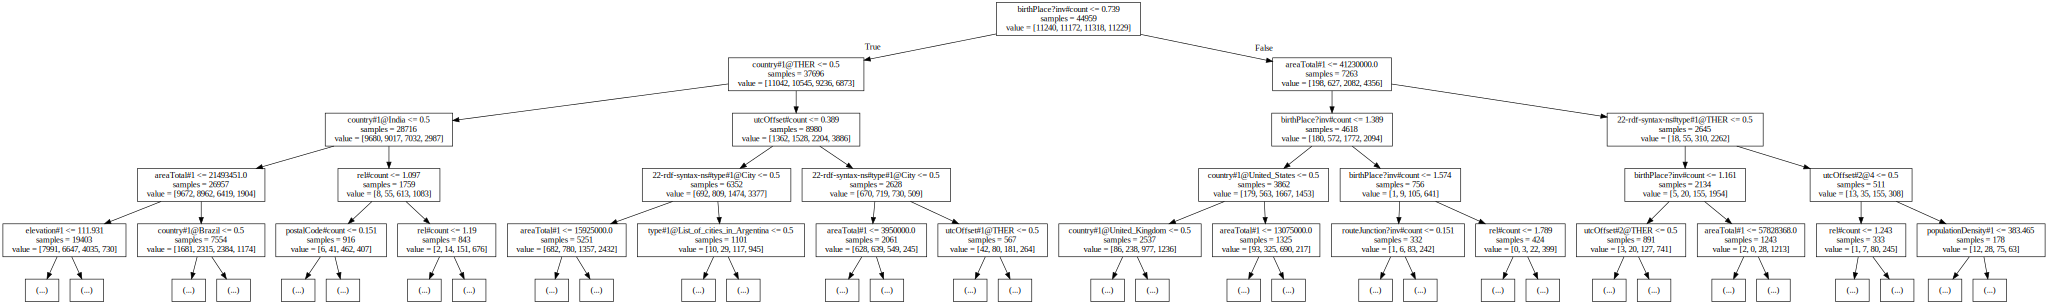

In [29]:
# CELL 29
import numpy as np
import pickle

with open("ch6_cell27_splits.pk", "rb") as pkl:
    segments_at = pickle.load(pkl)

data = list()
header = None
with open("ch6_cell28_dev_feat1_filtered.tsv") as feats:
    header = next(feats)
    header = header.strip().split("\t")
    header.pop(0) # name
    header.pop() # pop
    for line in feats:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        row = (feats, logpop, name)
        data.append(row)

xdata = np.array(list(map(lambda t:t[0], data)))
ydata = np.array(list(map(lambda t:t[1], data)))

ydata = cell28_adjudicate(ydata, segments_at[2])
print_names = list()
for name in header:
    name = name.replace('"','')
    if '@' in name:
        pos = name.find('@')
        rel, val = name[0:pos], name[pos+2:]
        rel = rel.replace('<','').replace('>','').split("/")[-1]
        val = val.replace('<','').replace('>','').split("/")[-1]
        name = "{}@{}".format(rel, val)
    else:
        name = name.replace('<','').replace('>','').split("/")[-1]
    print_names.append(name)   

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(xdata, ydata)

import graphviz
dot_data = tree.export_graphviz(clf, out_file=None, max_depth=4,
                               impurity=False, proportion=False,
                               feature_names=print_names)
graph = graphviz.Source(dot_data)
graph.render("ch6_cell29_tree.dot")
graph

# Second Featurization

From the previous analysis I decided to a computable feature using $area \times density$ and to perform an out-of-fold target-rate encoding in Cell #30, producing "ch6_cell30_dev_feats2_train.tsv" and "ch6_cell30_dev_feats2_test.tsv".

Due to the impossiblity of doing TRE and normalization, this new feature set is already normalized.


Training on 35,971 cities
RMSE 0.3298424854334205
Writing files for error analysis


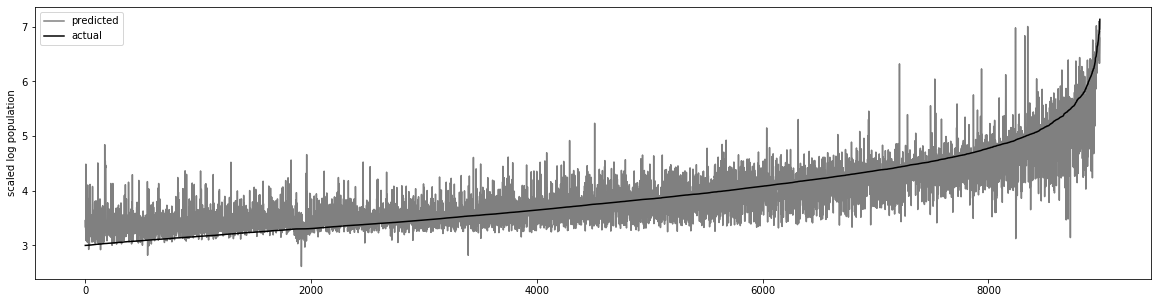

In [30]:
# CELL 30
import random
from functools import reduce
from sklearn.svm import SVR
import numpy as np
from collections import OrderedDict

rand = random.Random(42)
train_data = list()
test_data  = list()
header = None
with open("ch6_cell28_dev_feat1_filtered.tsv") as feats:
    header = next(feats)
    header = header.strip().split("\t")
    header.pop(0) # name
    header.pop() # population
    for line in feats:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        row = (feats, logpop, name)
        if rand.random() < 0.2:
            test_data.append(row) 
        else:
            train_data.append(row)
               
test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))

# add computed feature density area times
approx_area_train = np.zeros( (xtrain.shape[0],) )
approx_area_test  = np.zeros( (xtest.shape[0],)  )
#BUG "area#1" is not included here. It should
for idx, name in enumerate(header):
    if "#count" not in name and ("areaLand#" in name or "areaTotal#" in name):
        approx_area_train = np.max( [ approx_area_train, xtrain[:,idx] ], axis=0)
        approx_area_test =  np.max( [ approx_area_test, xtest[:,idx] ], axis=0)
density_idx = next(filter(lambda t:"populationDensity#1" in t[1], 
                     enumerate(header)))[0]
computed_value_train = approx_area_train * xtrain[:,density_idx]
computed_value_test  = approx_area_test  * xtest[:, density_idx]
computed_defined_train = np.array( list(map(lambda x: 1.0 if x>0 else 0.0, 
                                            computed_value_train)) )
computed_defined_test  = np.array( list(map(lambda x: 1.0 if x>0 else 0.0, 
                                           computed_value_test)) )
computed_value_train = np.log(computed_value_train + 1)
computed_value_test  = np.log(computed_value_test  + 1)
header.append("computed#defined")
header.append("computed#value")
xtrain = np.append(xtrain, computed_defined_train.reshape( (xtrain.shape[0],1) ), axis=1)
xtrain = np.append(xtrain, computed_value_train.reshape(   (xtrain.shape[0],1) ), axis=1)
xtest  = np.append(xtest,  computed_defined_test.reshape(  (xtest.shape[0],1) ),  axis=1)
xtest  = np.append(xtest,  computed_value_test.reshape(    (xtest.shape[0],1) ),  axis=1)

# out-of-fold target encoding for tsv
xtrain_non_tre = xtrain.copy()
xtest_non_tre  = xtest.copy()

def doTRE(xtrain, ytrain, xtest, ytest):
    PARAM_FOLDS = 10
    PARAM_ADD_ORIGINAL_COLS = True
    PARAM_SINGLE_COL_TRE = True
    folds = list(map(lambda x:rand.randint(0, PARAM_FOLDS - 1), range(xtrain.shape[0])))
    # value to use when there is no evidence available
    imputed_tre = sorted(list(ytrain))[int(ytrain.shape[0]/2)]
    
    # gather the TRE cols
    tre_cols = list()
    tre_col_names = list()
    cols_to_tre_cols = dict()
    cats_for_attrib = OrderedDict() # name to list of idx
    for idx, name in enumerate(header):
        if '@' in name: # categorical value
            tre_idx = len(tre_cols)
            cols_to_tre_cols[idx] = tre_idx
            tre_cols.append(idx)
            tre_col_names.append(name + '+TRE')
            attrib = name[0:name.index('@')]
            if attrib not in cats_for_attrib:
                cats_for_attrib[attrib] = []
            cats_for_attrib[attrib].append( (idx, tre_idx) )
    tre_train = np.zeros( (xtrain.shape[0], len(tre_cols)) )
    tre_test  = np.zeros( (xtest.shape[0],  len(tre_cols)) )
    
    saved_full_TRE = OrderedDict()
    
    for idx, name in enumerate(header):
        if '@' in name: # categorical value
            tre_col = cols_to_tre_cols[idx]
            
            fold_val_pops = { fold: dict() for fold in range(PARAM_FOLDS) }
            # gather the pop values for the features in all folds
            for row in range(xtrain.shape[0]):
                value = xtrain[row, idx]
                fold = folds[row]
                fold_val_pops[fold][value] = fold_val_pops[fold].get(value, []) + [ytrain[row]]
            all_values = set(xtrain[:,idx]).union(set(xtest[:,idx]))
            # compute TREs
            fold_TREs = list()
            for fold in range(PARAM_FOLDS):
                val_pops = dict()
                for other in range(PARAM_FOLDS):
                    if other != fold:
                        for value in fold_val_pops[other].keys():
                            val_pops[value] = val_pops.get(value, []) + fold_val_pops[other][value]
                fold_TRE = OrderedDict()
                for value in all_values:
                    val_pops[value] = sorted(val_pops.get(value, []))
                    fold_TRE[value] = imputed_tre if len(val_pops[value]) == 0 else \
                      val_pops[value][int(len(val_pops[value])/2)]
                fold_TREs.append(fold_TRE)
            full_val_pops = dict()
            for value in all_values:
                full_val_pops[value] = sorted(reduce(lambda x, y: x + y, 
                                                  map(lambda f:f.get(value, []), fold_val_pops.values()), []))
            full_TRE = OrderedDict()
            for value in all_values:
                full_TRE[value] = imputed_tre if len(full_val_pops[value]) == 0 \
                   else full_val_pops[value][int(len(full_val_pops[value])/2)]

            # encode folds
            for row in range(xtrain.shape[0]):
                tre_train[row, tre_col] = fold_TREs[folds[row]][xtrain[row, idx]]
            # encode test (full TRE)
            for row in range(xtest.shape[0]):
                tre_test[row, tre_col] = full_TRE[xtest[row, idx]]
            saved_full_TRE[idx] = full_TRE
            
    if PARAM_SINGLE_COL_TRE:
        single_tre_train = np.zeros( (xtrain.shape[0], len(cats_for_attrib)) )
        single_tre_test  = np.zeros( (xtest.shape[0],  len(cats_for_attrib)) )
        single_tre_col_names = list()
        single_tre_count = 0
        for attrib, idxs in cats_for_attrib.items():
            single_tre_col_names.append(attrib + '#TRE')
            for row in range(xtrain.shape[0]):
                max_tre_idx = None
                max_val = None
                for idx, tre_idx in idxs:
                    if max_tre_idx is None or xtrain[row,idx] > max_val:
                        max_val = xtrain[row,idx]
                        max_tre_idx = tre_idx
                single_tre_train[row,single_tre_count] = tre_train[row,tre_idx]
            for row in range(xtest.shape[0]):
                max_tre_idx = None
                max_val = None
                for idx, tre_idx in idxs:
                    if max_tre_idx is None or xtest[row,idx] > max_val:
                        max_val = xtest[row,idx]
                        max_tre_idx = tre_idx
                single_tre_test[row,single_tre_count] = tre_test[row,tre_idx]
            single_tre_count += 1
        tre_train = single_tre_train
        tre_test  = single_tre_test
        tre_col_names = single_tre_col_names

    if not PARAM_ADD_ORIGINAL_COLS:
        # delete original columns
        xtrain = np.delete(xtrain, tre_cols, 1)
        xtest  = np.delete(xtest,  tre_cols, 1)
        for idx in reversed(tre_cols):
            del header[idx]
            
    # add tre columns
    header.extend(tre_col_names)
    xtrain = np.append(xtrain, tre_train, axis=1)
    xtest = np.append(xtest, tre_test, axis=1)
    
    return header, xtrain, ytrain, xtest, ytest, saved_full_TRE

PARAM_WRITE_UNSCALED = False
if PARAM_WRITE_UNSCALED:
    new_header, xtrain, ytrain, xtest, ytest, _ = doTRE(xtrain, ytrain, xtest, ytest)

    # write new data
    with open("ch6_cell30_dev_feats2_train_raw.tsv", "w") as feats:
        feats.write("\t".join(["name"] + new_header + ["population"])+"\n")
        arr, target, names = xtrain, ytrain, list(map(lambda t:t[2],train_data))
        for row in range(arr.shape[0]):
            feats.write("\t".join(list(map(lambda v:str(v),
                                       [names[row]]+list(arr[row,:])+[target[row]]))) +"\n")
    with open("ch6_cell30_dev_feats2_test_raw.tsv", "w") as feats:
        feats.write("\t".join(["name"] + new_header + ["population"])+"\n")
        arr, target, names = xtest, ytest, test_names
        for row in range(arr.shape[0]):
            feats.write("\t".join(list(map(lambda v:str(v),
                                       [names[row]]+list(arr[row,:])+[target[row]]))) +"\n")

# need to re-do tre after scaling
xtrain = xtrain_non_tre
xtest  = xtest_non_tre

# SVRs need scaling
xtrain_min = xtrain.min(axis=0); xtrain_max = xtrain.max(axis=0)
# some can be zero if the column is constant in training
xtrain_diff = xtrain_max - xtrain_min
for idx in range(len(xtrain_diff)):
    if xtrain_diff[idx] == 0.0:
        xtrain_diff[idx] = 1.0
xtrain_scaling = 1.0 / xtrain_diff
xtrain -= xtrain_min; xtrain *= xtrain_scaling

ytrain_min = ytrain.min(); ytrain_max = ytrain.max()
ytrain_scaling = 1.0 / (ytrain_max - ytrain_min)
ytrain -= ytrain_min; ytrain *= ytrain_scaling

xtest -= xtrain_min; xtest *= xtrain_scaling
ytest_orig = ytest.copy()
ytest -= ytrain_min; ytest *= ytrain_scaling

# redo TRE after scaling
header, xtrain, ytrain, xtest, ytest, saved_full_TRE = doTRE(xtrain, ytrain, xtest, ytest)

np.savez_compressed("ch6_cell30_scaled_full_TRE.npz", 
                    saved_full_TRE = saved_full_TRE,
                   xtrain_min      = xtrain_min,
                   xtrain_scaling  = xtrain_scaling,
                   ytrain_min      = ytrain_min,
                   ytrain_scaling  = ytrain_scaling)
with open("ch6_cell30_dev_feats2_train.tsv", "w") as feats:
    feats.write("\t".join(["name"] + header + ["population"])+"\n")
    arr, target, names = xtrain, ytrain, list(map(lambda t:t[2],train_data))
    for row in range(arr.shape[0]):
        feats.write("\t".join(list(map(lambda v:str(v),
                                   [names[row]]+list(arr[row,:])+[target[row]]))) +"\n")
with open("ch6_cell30_dev_feats2_test.tsv", "w") as feats:
    feats.write("\t".join(["name"] + header + ["population"])+"\n")
    arr, target, names = xtest, ytest, test_names
    for row in range(arr.shape[0]):
        feats.write("\t".join(list(map(lambda v:str(v),
                                   [names[row]]+list(arr[row,:])+[target[row]]))) +"\n")


# train
print("Training on {:,} cities".format(len(xtrain)))

best_c = 100.0
best_epsilon = 0.05
PARAM_DO_GRID_SEARCH = False
if PARAM_DO_GRID_SEARCH:
    best_rmse = 1000
    for c in [0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 15.0, 100.0]:
        svr_rbf = SVR(epsilon=0.01, C=c, gamma='auto')
        svr_rbf.fit(xtrain, ytrain)
        ytest_pred = svr_rbf.predict(xtest)
        ytest_pred *= 1.0/ytrain_scaling
        ytest_pred += ytrain_min
        RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
        print("C", c, "RMSE", RMSE)
        if RMSE < best_rmse:
            best_c = c
            best_rmse = RMSE
    print("Best C", best_c,"best RMSE", best_rmse)        

    best_epsilon = 0.1
    best_rmse = 1000
    for epsilon in [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.0, 1.0, 10.0, 100.0]:
        svr_rbf = SVR(epsilon=epsilon, C=best_c, gamma='auto')
        svr_rbf.fit(xtrain, ytrain)
        ytest_pred = svr_rbf.predict(xtest)
        ytest_pred *= 1.0/ytrain_scaling
        ytest_pred += ytrain_min
        RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
        print("Epsilon", epsilon, "RMSE", RMSE)
        if RMSE < best_rmse:
            best_epsilon = epsilon
            best_rmse = RMSE
    print("Best epsilon", best_epsilon,"best RMSE", best_rmse)

svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
svr_rbf.fit(xtrain, ytrain)
ytest_pred = svr_rbf.predict(xtest)
ytest_pred *= 1.0/ytrain_scaling
ytest_pred += ytrain_min
RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

print("Writing files for error analysis")
np.savez_compressed("ch6_cell30_feat2_svr.npz", 
                    xtrain=xtrain, ytrain=ytrain, 
                    xtest=xtest, ytest=ytest,
                    ytest_orig=ytest_orig,
                    ytest_pred=ytest_pred,
                    xtrain_scaling=xtrain_scaling,
                    ytrain_scaling=ytrain_scaling)
with open("ch6_cell30_test_names.tsv", "w") as names:
    for idx, name in enumerate(test_names):
        names.write("{}\t{}\n".format(idx, name))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest_orig, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch6_cell30_svr_feat2.pdf", bbox_inches='tight', dpi=300)
plt.legend()

Adding back the original columns increases the number of columns to 577 from 314 but it reduces the RMSE to 0.3366 (otherwise it stays on 0.3514). This constitutes the best feature set to be used in the final evaluation.

I'll now focus on selecting features that are stable under test error, that is, that can cope with a training set that is an incorrect sample of the feature.

For that, I'll borrow a technique from privacy preserving data mining and introduce noise to the data by swapping the value of a given feature between two instances. Doing this swapping at a given percentage creates a test set that has been perturbed at a certain level. For these experiments, I will arbitrarily use a perturbation of 30%.

For a conservative feature set, I will be willing to let go of features that, when perturbed at 30% produce a drop on performance greater than the drop resulting for keeping them.

Sadly, as features are dependent, we'll need to retrain the base model every time a feature is deleted. Cell #31

In [31]:
# CELL 31
import random
import datetime
from sklearn.svm import SVR
import numpy as np

rand = random.Random(41) # 41 has areaLand and US; 39 areaLand and Brazil
train_data = list()
test_data  = list()
header = None
with open("ch6_cell30_dev_feats2_train.tsv") as feats:
    header = next(feats)
    header = header.strip().split("\t")
    header.pop(0) # name
    header.pop()  # population
    for line in feats:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name  = fields[0]
        feats = list(map(float,fields[1:-1]))
        row   = (feats, logpop, name)
        train_data.append(row)
with open("ch6_cell30_dev_feats2_test.tsv") as feats:
    _ = next(feats)
    for line in feats:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name  = fields[0]
        feats = list(map(float,fields[1:-1]))
        row   = (feats, logpop, name)
        test_data.append(row) 
               
test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))

# sample the data to finish in a reasonable amount of time
selected = rand.sample(list(range(len(xtrain))), int(len(xtrain) * 0.2))
xtrain = xtrain[selected,:]
ytrain = ytrain[selected]

selected = rand.sample(list(range(len(xtest))), int(len(xtest) * 0.2))
xtest = xtest[selected,:]
ytest = ytest[selected]

dropped_features = list()
rand = random.Random(42)

best_c       = 100.0
best_epsilon = 0.05
PARAM_PERTURBATION_PERC = 0.3
PARAM_SAMPLES           = 3
PARAM_FIRST_SAMPLES     = 999
start_error = None
end_error   = None
while True:
    print(datetime.datetime.now().isoformat(), "=== Total features", xtrain.shape[1], "===")
    # train base system
    full_svr = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
    full_svr.fit(xtrain, ytrain)
    print(datetime.datetime.now().isoformat(), "Base model trained")
    
    # do wrapper
    feature_loss = list()
    selected     = rand.sample(list(range(len(xtrain))), int(len(xtrain) * 0.1))
    xtrain_samp = xtrain[selected,:]
    ytrain_samp = ytrain[selected]
    
    svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
    svr_rbf.fit(xtrain_samp, ytrain_samp)
    ytest_pred = svr_rbf.predict(xtest)
    base_error = math.sqrt( sum((ytest_pred - ytest)**2) )
    print(datetime.datetime.now().isoformat(), "Sampled model trained")
    for feat in range(xtrain.shape[1]):
        if feat % int(xtrain.shape[1] / 10) == 0:
            print(datetime.datetime.now().isoformat(), "ablation, {:>3} out of {:>3}".format(feat, xtrain.shape[1]))
        train_col = xtrain_samp[:,feat].copy()
        xtrain_samp[:,feat] = 0.0 # nuke feature
        svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
        svr_rbf.fit(xtrain_samp, ytrain_samp)
        ytest_pred = svr_rbf.predict(xtest)
        error = math.sqrt( sum((ytest_pred - ytest)**2) )
        feature_loss.append(base_error - error)
        xtrain_samp[:,feat] = train_col # restore
    while len(feature_loss) < xtrain.shape[1]:
        feature_loss.append(999)

    # do perturbation error
    ytest_pred = full_svr.predict(xtest)
    base_error = math.sqrt( sum( (ytest_pred - ytest)**2 ) )
    if start_error is None:
        start_error = base_error
    end_error = base_error
    
    # perturbed samples
    perturbed = list()
    for _ in range(PARAM_SAMPLES):
        xtest_perturbed = xtest.copy()
        for _ in range(int(xtest.shape[0] * PARAM_PERTURBATION_PERC * 2)):
            a = rand.randint(0, xtest.shape[0] - 1)
            b = rand.randint(0, xtest.shape[0] - 1)
            xtest_perturbed[ [a,b], :] = xtest_perturbed[ [b,a], :]
        perturbed.append(xtest_perturbed)
    print(datetime.datetime.now().isoformat(), 
          "perturbation at {} finished for {} samples".format(PARAM_PERTURBATION_PERC, PARAM_SAMPLES))

    perturbed_error = list()
    for feat in range(min(PARAM_FIRST_SAMPLES, xtrain.shape[1])):
        if feat % int(xtrain.shape[1] / 10) == 0:
            print(datetime.datetime.now().isoformat(), "perturbation, {:>3} out of {:>3}".format(feat, xtrain.shape[1]))
        errors = list()
        test_col = xtest[:,feat].copy()
        for idx in range(PARAM_SAMPLES):
            xtest[:,feat] = perturbed[idx][:,feat]
            ytest_pred = full_svr.predict(xtest)
            errors.append( base_error - math.sqrt( sum((ytest_pred - ytest)**2) ) )
        xtest[:,feat] = test_col
        perturbed_error.append(sorted(errors)[int(len(errors)/2)])
    while len(perturbed_error) < xtrain.shape[1]:
        perturbed_error.append(1)
        
    # pick the feature to drop
    feat_to_drop = None
    best_ratio = None
    droppable_count = 0
    for feat in range(min(PARAM_FIRST_SAMPLES, xtrain.shape[1])):
        if perturbed_error[feat] > 0 and feature_loss[feat] > 0 and perturbed_error[feat] > feature_loss[feat]:
            droppable_count += 1
            ratio = feature_loss[feat] / perturbed_error[feat]
            print(datetime.datetime.now().isoformat(), "Feature",header[feat], "ablated", feature_loss[feat], 
                  "perturbed",perturbed_error[feat], "ratio", ratio)
            if feat_to_drop is None or best_ratio > ratio:
                feat_to_drop = feat
                best_ratio = ratio
    print("Droppable features", droppable_count, "out of", xtrain.shape[1])
    if feat_to_drop is None:
        break # done
    
    # drop feature
    print(datetime.datetime.now().isoformat(), "Dropped", header[feat_to_drop])
    dropped_features.append(header[feat_to_drop])
    del header[feat_to_drop]
    xtrain = np.delete(xtrain, feat_to_drop, 1)
    xtest = np.delete(xtest, feat_to_drop, 1)
    
    if xtrain.shape[1] == 0:
        break # shouldn't happen
        
print(datetime.datetime.now().isoformat(), "Final number of features",xtrain.shape[1])
print(datetime.datetime.now().isoformat(), "Start error", start_error)
print(datetime.datetime.now().isoformat(), "Final error", end_error)

# write'em
with open("ch6_cell31_features_dropped.txt", "w") as dropped:
    for featname in dropped_features:
        dropped.write(featname + "\n")

with open("ch6_cell31_dev_train.tsv", "w") as feats:
    feats.write("\t".join(["name"] + header + ["population"])+"\n")
    arr, target, names = xtrain, ytrain, list(map(lambda t:t[2],train_data))
    for row in range(arr.shape[0]):
        feats.write("\t".join(list(map(lambda v:str(v),
                                   [names[row]]+list(arr[row,:])+[target[row]]))) +"\n")
with open("ch6_cell31_dev_test.tsv", "w") as feats:
    feats.write("\t".join(["name"] + header + ["population"])+"\n")
    arr, target, names = xtest, ytest, test_names
    for row in range(arr.shape[0]):
        feats.write("\t".join(list(map(lambda v:str(v),
                                   [names[row]]+list(arr[row,:])+[target[row]]))) +"\n")

2019-11-25T13:21:04.493754 === Total features 325 ===
2019-11-25T13:21:26.182054 Base model trained
2019-11-25T13:21:26.838139 Sampled model trained
2019-11-25T13:21:26.838293 ablation,   0 out of 325
2019-11-25T13:21:47.601105 ablation,  32 out of 325
2019-11-25T13:22:08.500160 ablation,  64 out of 325
2019-11-25T13:22:29.318456 ablation,  96 out of 325
2019-11-25T13:22:50.153342 ablation, 128 out of 325
2019-11-25T13:23:11.025659 ablation, 160 out of 325
2019-11-25T13:23:31.847387 ablation, 192 out of 325
2019-11-25T13:23:52.624032 ablation, 224 out of 325
2019-11-25T13:24:13.417617 ablation, 256 out of 325
2019-11-25T13:24:34.250685 ablation, 288 out of 325
2019-11-25T13:24:55.108534 ablation, 320 out of 325
2019-11-25T13:25:01.536526 perturbation at 0.3 finished for 3 samples
2019-11-25T13:25:01.536699 perturbation,   0 out of 325
2019-11-25T13:30:05.127399 perturbation,  32 out of 325
2019-11-25T13:35:03.919973 perturbation,  64 out of 325
2019-11-25T13:40:07.095331 perturbation, 

2019-11-25T16:58:12.528099 Base model trained
2019-11-25T16:58:13.181583 Sampled model trained
2019-11-25T16:58:13.181736 ablation,   0 out of 321
2019-11-25T16:58:33.904325 ablation,  32 out of 321
2019-11-25T16:58:54.610138 ablation,  64 out of 321
2019-11-25T16:59:15.285013 ablation,  96 out of 321
2019-11-25T16:59:36.014337 ablation, 128 out of 321
2019-11-25T16:59:56.781831 ablation, 160 out of 321
2019-11-25T17:00:17.492602 ablation, 192 out of 321
2019-11-25T17:00:38.177330 ablation, 224 out of 321
2019-11-25T17:00:58.846890 ablation, 256 out of 321
2019-11-25T17:01:19.613439 ablation, 288 out of 321
2019-11-25T17:01:40.321650 ablation, 320 out of 321
2019-11-25T17:01:44.149575 perturbation at 0.3 finished for 3 samples
2019-11-25T17:01:44.149761 perturbation,   0 out of 321
2019-11-25T17:06:38.764254 perturbation,  32 out of 321
2019-11-25T17:11:32.003665 perturbation,  64 out of 321
2019-11-25T17:16:26.601171 perturbation,  96 out of 321
2019-11-25T17:21:22.294422 perturbation

2019-11-25T20:29:08.165877 Sampled model trained
2019-11-25T20:29:08.166037 ablation,   0 out of 317
2019-11-25T20:29:26.712355 ablation,  31 out of 317
2019-11-25T20:29:45.119118 ablation,  62 out of 317
2019-11-25T20:30:03.689109 ablation,  93 out of 317
2019-11-25T20:30:22.226278 ablation, 124 out of 317
2019-11-25T20:30:40.765717 ablation, 155 out of 317
2019-11-25T20:30:59.321678 ablation, 186 out of 317
2019-11-25T20:31:17.905135 ablation, 217 out of 317
2019-11-25T20:31:36.504862 ablation, 248 out of 317
2019-11-25T20:31:54.956919 ablation, 279 out of 317
2019-11-25T20:32:13.476735 ablation, 310 out of 317
2019-11-25T20:32:20.717909 perturbation at 0.3 finished for 3 samples
2019-11-25T20:32:20.718091 perturbation,   0 out of 317
2019-11-25T20:36:58.584525 perturbation,  31 out of 317
2019-11-25T20:41:36.920274 perturbation,  62 out of 317
2019-11-25T20:46:22.118936 perturbation,  93 out of 317
2019-11-25T20:51:08.548078 perturbation, 124 out of 317
2019-11-25T20:55:48.923326 pe

The previous cell results suggest dropping countries but that is counter-intuitive as they are the most stable features. Based on this realization, I assemble a "more conservative set" using only counts and country features, with no TRE (Cell #32).

Read 3,424 countries
Training on 35,940 cities
RMSE 0.357821756992853


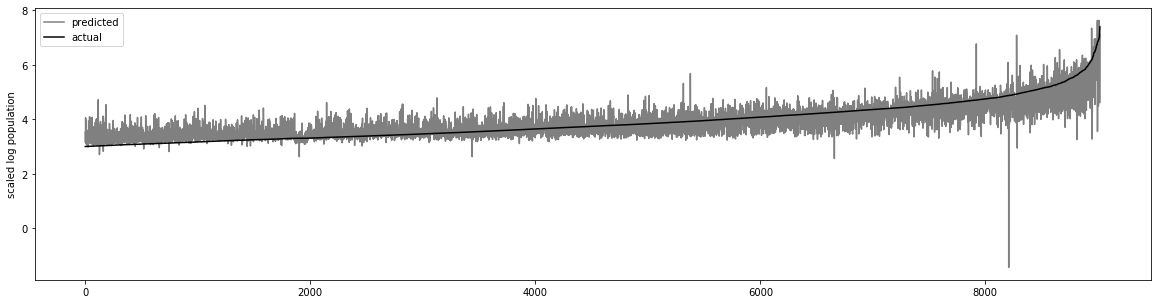

In [32]:
# CELL 32
import bz2
import re
from sklearn.svm import SVR
import numpy as np

triple_re = re.compile("(<[^>]+>)\s(<[^>]+>)\s(.*) \.")

def compressed_triples_gen(filename):
    with bz2.BZ2File(filename,"r") as compressed:
        for byteline in compressed:
            if byteline[0] == ord('#'):
                continue
            line = byteline.decode("utf-8")
            s,v,o = triple_re.match(line).groups()
            yield line,s,v,o
            
# determine country names, from DBpedia
countries = list()
for line, subj, verb, obj in compressed_triples_gen("instance_types_en.ttl.bz2"):
    if obj == '<http://dbpedia.org/ontology/Country>':
        countries.append(subj[len("http://dbpedia.org/resource"):])
print("Read {:,} countries".format(len(countries)))

# read dataset
train_data = list()
test_data  = list()
header = None
devtrain = set()
with open("devtrain.txt") as train:
    # for stable results due to a missing seed
    for city in train:
        devtrain.add(city.strip())
with open("ch6_cell28_dev_feat1_filtered.tsv") as feats:
    header = next(feats)
    header = header.strip().split("\t")
    header.pop(0) # name
    header.pop() # population
    for line in feats:
        fields = line.strip().split("\t")
        logpop = float(fields[-1])
        name = fields[0]
        feats = list(map(float,fields[1:-1]))
        row = (feats, logpop, name)
        #if rand.random() < 0.2:
        if name not in devtrain:
            test_data.append(row) 
        else:
            train_data.append(row)
               
train_names = list(map(lambda t:t[2], train_data))

test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))

# computed feature density area times
approx_area_train = np.zeros( (xtrain.shape[0],) )
approx_area_test  = np.zeros( (xtest.shape[0],)  )
for idx, name in enumerate(header):
    if "#count" not in name and ("areaLand#" in name or "areaTotal#" in name):
        approx_area_train = np.max( [ approx_area_train, xtrain[:,idx] ], axis=0)
        approx_area_test  = np.max( [ approx_area_test,  xtest[:,idx]  ], axis=0)
density_idx = next(filter(lambda t:"populationDensity#1" in t[1], 
                     enumerate(header)))[0]
computed_value_train = approx_area_train * xtrain[:,density_idx]
computed_value_test  = approx_area_test  * xtest[:, density_idx]
computed_defined_train = np.array( list(map(lambda x: 1.0 if x>0 else 0.0, 
                                            computed_value_train)) )
computed_defined_test  = np.array( list(map(lambda x: 1.0 if x>0 else 0.0, 
                                            computed_value_test))  )
computed_value_train = np.log(computed_value_train + 1)
computed_value_test  = np.log(computed_value_test  + 1)

# filter categories not containing a country
to_delete = list()
for idx, name in enumerate(header):
    keep = True
    if '@' in name:
        keep = False
        for country in countries:
            if country in name:
                keep = True
                break
    if not keep:
        to_delete.append(idx)
xtrain = np.delete(xtrain, to_delete, 1)
xtest  = np.delete(xtest,  to_delete, 1)
for idx in reversed(to_delete):
    del header[idx]

# add computed feature
header.append("computed#defined")
header.append("computed#value")
xtrain = np.append(xtrain, computed_defined_train.reshape( (xtrain.shape[0],1) ), axis=1)
xtrain = np.append(xtrain, computed_value_train.reshape(   (xtrain.shape[0],1) ), axis=1)
xtest  = np.append(xtest,  computed_defined_test.reshape(  (xtest.shape[0], 1) ), axis=1)
xtest  = np.append(xtest,  computed_value_test.reshape(    (xtest.shape[0], 1) ), axis=1)

# write full file
with open("ch6_cell32_dev_feat_conservative.tsv",  "w") as f:
    f.write("name\t" + "\t".join(header) + '\tpopulation\n')
    for row in range(xtrain.shape[0]):
        f.write(train_names[row] + '\t' + '\t'.join(map(str,xtrain[row,:]))+ '\t' + str(ytrain[row]) + '\n')
    for row in range(xtest.shape[0]):
        f.write(test_names[row] +  '\t' + '\t'.join(map(str,xtest[row,:])) + '\t' + str(ytest[row])  + '\n')

# train SVR
xtrain_min = xtrain.min(axis=0); xtrain_max = xtrain.max(axis=0)
# some can be zero if the column is constant in training
xtrain_diff = xtrain_max - xtrain_min
for idx in range(len(xtrain_diff)):
    if xtrain_diff[idx] == 0.0:
        xtrain_diff[idx] = 1.0
xtrain_scaling = 1.0 / xtrain_diff
xtrain -= xtrain_min; xtrain *= xtrain_scaling

ytrain_min = ytrain.min(); ytrain_max = ytrain.max()
ytrain_scaling = 1.0 / (ytrain_max - ytrain_min)
ytrain -= ytrain_min; ytrain *= ytrain_scaling

xtest -= xtrain_min; xtest *= xtrain_scaling
ytest_orig = ytest.copy()
ytest -= ytrain_min; ytest *= ytrain_scaling

# train
print("Training on {:,} cities".format(len(xtrain)))

best_c = 100.0
best_epsilon = 0.05
svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
svr_rbf.fit(xtrain, ytrain)
ytest_pred = svr_rbf.predict(xtest)
ytest_pred *= 1.0/ytrain_scaling
ytest_pred += ytrain_min
RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest_orig, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch6_cell32_svr_feat_conservative.pdf", bbox_inches='tight', dpi=300)
plt.legend()

Follow ups left to the reader:

* go back to the source data and encode the selected relations as sets
* gps coordinates
* add the countries explicitly
* out-of-fold cluster the categories by their behaviour with the target class rather than by sheer counts
* add an out-of-fold feature as the result of the decision tree (need to add "ensemble systems as out-of-fold computable features" to chapter 3).
* final evaluation on held out

Final systems:

Assemble baseline system using feature stability and feat2 as good, with expected scores to get <- baseline: total count, plus area times density, country target rate encoded

* number of relations, utc, density, areatotal, country with interpolated RFs (baseline)
* baseline + more features including some target rate encoding, using a SVR (improved)
